 ==> Librerías, clases y métodos cargados:
 +++ "dt"                           +++ "os" 
 +++ "json" v:2.0.9                 +++ "pd" (pandas) v:0.18.1
 +++ "locale"                       +++ "plt" 
 +++ "math"                         +++ "re" v:2.2.1
 +++ "np" (numpy) v:1.11.1          +++ "sns" (seaborn) v:0.7.0
 +++ "sys" 
 ** "Colormap", "Line2D", "Normalize", "OrderedDict", "PathPatch", "namedtuple", "time"
 ==> Pretty printing funcs:
print_blue, print_bold, print_boldu, print_cyan, print_err, print_green, print_grey, print_greyb, print_info, print_infob, print_magenta, print_ok, print_red, print_redb, print_secc, print_tree_dict, print_warn, print_white, print_yellow, print_yellowb, printcolor
If you are in a jupyter notebook, insert this:
%matplotlib inline
%config InlineBackend.figure_format='retina'
If you are working with GEO data, insert this:
import geopandas as gpd
import shapely.geometry as sg
import cartopy.crs as ccrs


/Users/uge/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


***TIMEIT get_all_data TOOK: 1.085 s
                          kWh     t_ref  n_jump  n_exec   p_max  p_mean  p_min
ts                                                                            
2016-09-14 09:00:00  0.280975  0.999865       0       0   865.0   281.0  185.0
2016-09-14 10:00:00  0.348163  1.000116       0       0   422.0   348.0  273.0
2016-09-14 11:00:00  0.347181  1.000035       0       0   883.0   347.0  277.0
2016-09-14 12:00:00  0.312149  0.999837       0       0   391.0   312.0  269.0
2016-09-14 13:00:00  0.144251  0.331557       0       0  2564.0   435.0  284.0
       count  mean  std  min  25%  50%  75%  max
ldr  2725278   251  234   11   33  162  478  748


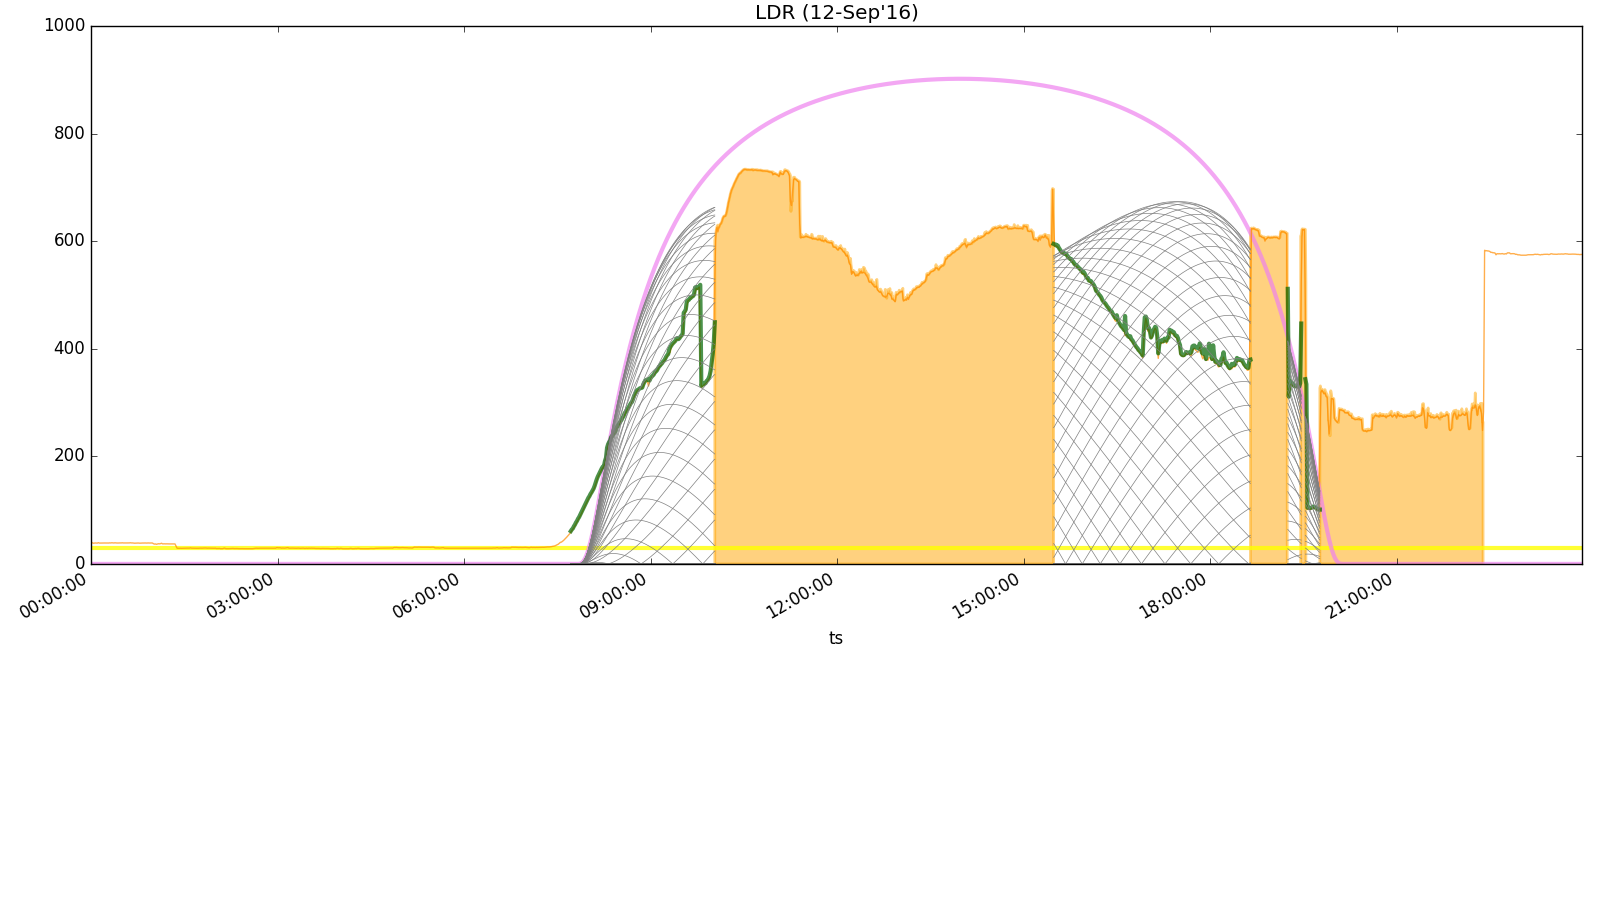

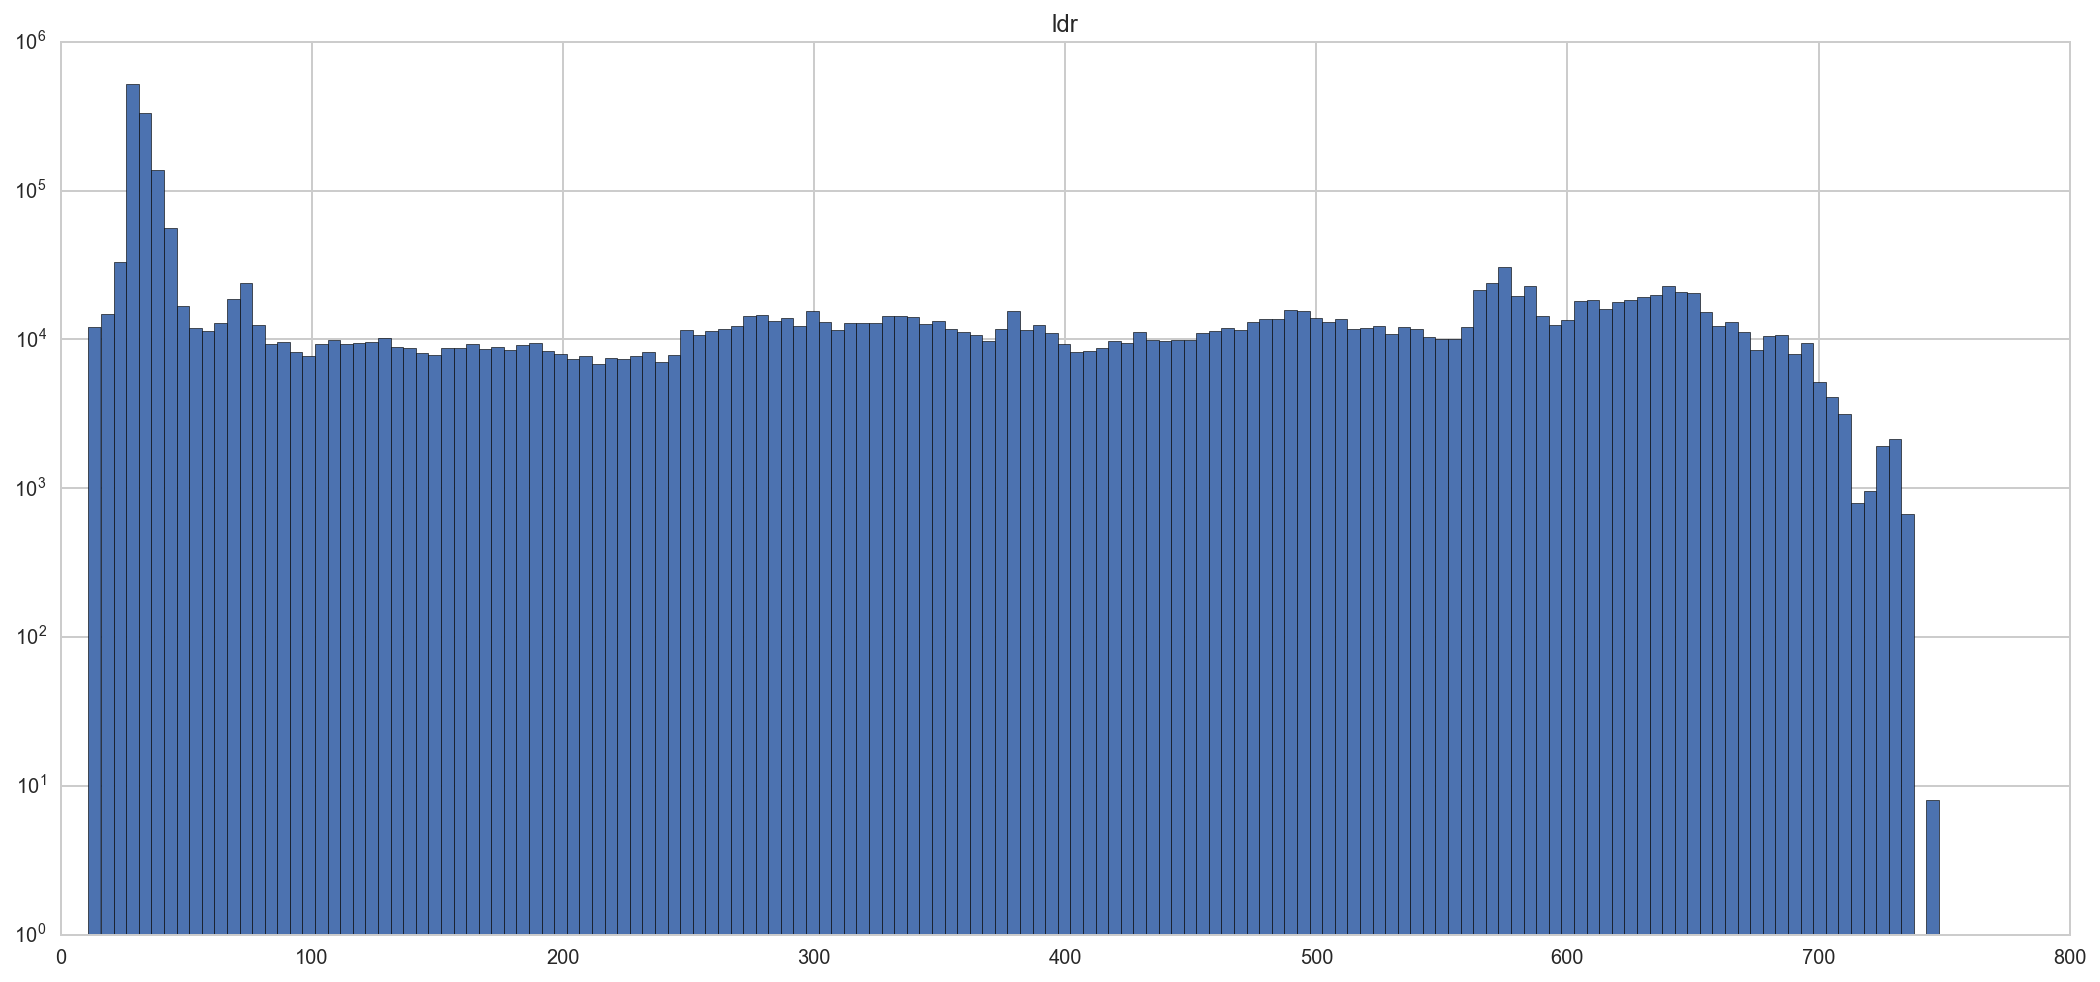

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
from IPython.display import Image, HTML

import random
import math
import pysolar
import datetime as dt
import pytz
import matplotlib.dates as mpd
import scipy
from scipy import signal
from scipy.signal import medfilt
import numexpr as ne

from datacharm import *
from datacharm.dataplots import tableau20, ch_color

from enerpi.base import timeit
from enerpi.api import enerpi_data_catalog
from enerpi.enerplot import plot_tile_last_24h, plot_power_consumption_hourly
from enerpi.process import separa_ldr_artificial_natural, get_solar_day
from enerpi.radsolar import ajuste_ldr_con_barrido_irrad_inc, local_maxima_minima


LAT = 38.631463
LONG = -0.866402
ELEV_M = 500
TZ = pytz.timezone('Europe/Madrid')
FS = (16, 10)


def _tslim(ax, h0=12, hf=22, m0=0, mf=0):
    xlim = [mpd.num2date(x, tz=TZ) for x in ax.get_xlim()]
    new = [mpd.date2num(d.replace(hour=h, minute=m)) for d, h, m in zip(xlim, [h0, hf], [m0, mf])]
    ax.set_xlim(new)
    return ax


def set_sun_times(df, tz=TZ, lat_deg=LAT, long_deg=LONG, offset='5min'):
    if df.index[-1].date() == df.index[0].date():
        # Same day:
        ts_day = pd.Timestamp(df.index[0].date(), tz=tz)
        sunrise, sunset = pysolar.util.get_sunrise_sunset(lat_deg, long_deg, ts_day + pd.Timedelta('12h'))
        delta = pd.Timedelta(offset)
        sunrise, sunset = [sunrise - delta, sunset + delta]
        df['sun'] = False
        df.loc[sunrise:sunset, 'sun'] = True
        return df
    else:
        print_err('IMPLEMENTAR!')
        assert()


sns.set_style('whitegrid')        

# Catálogo y lectura de todos los datos.
cat = enerpi_data_catalog()
data, data_s = cat.get_all_data()
print_info(data_s.tail())

LDR = pd.DataFrame(data.ldr).tz_localize(TZ)
print_cyan(LDR.describe().T.astype(int))
LDR.hist(bins=(LDR.max() - LDR.min() + 1).values[0] // 5, log=True, figsize=(18, 8))

Image('/Users/uge/Desktop/LDR_analysis/LDR_análisis_día_2016_09_12.png')

In [14]:
pois = pd.read_csv('/Users/uge/Desktop/LDR_analysis/POIS_labeled.h5_.csv').set_index('ts_fin')

labeled = pois[pois.solo_natural.notnull()].copy()
labeled.solo_natural = labeled.solo_natural.astype(bool)
labeled.artificial_princ = labeled.artificial_princ.astype(bool)

labeled.head()

intervalo  fr_sun  ini_sun  fin_sun  seconds  altitud    ldr_mean  ldr_median  pendiente_tot  inicio    fin  pendiente_i  pendiente_f  pendiente_last_mf  \
ts_fin                                                                                                                                                                          
2016-08-12 11:36:50        1.0     1.0      1.0      1.0   3005.0     44.0  648.910150       649.0      -0.051581   656.0  641.0    -0.010000    -0.171717          -0.048414   
2016-08-12 11:42:55        2.0     1.0      1.0      1.0    365.0     49.0  627.041096       634.0      -1.780822   610.0  636.0    -1.780822    -1.780822          -0.944444   
2016-08-12 11:59:50        4.0     1.0      1.0      1.0    965.0     51.0  630.113990       630.0       0.020725   636.0  632.0    -0.030000     0.040404           0.104167   
2016-08-12 12:07:15        6.0     1.0      1.0      1.0    355.0     54.0  422.042254       426.0       0.281690   411.0  426.0     0.281690     0.281690           0.157143   
2016-08-12 12:19:05       10.0     1.0      1.0      1.0    310.0     55.0  469.903226       470.5      -1.354839   482.0  464.0    -1.354839    -1.354839          -0.803279   

                                  ts_ini   step is_poi_to_label solo_natural artificial_princ  
ts_fin                                                                                         
2016-08-12 11:36:50  2016-08-12 10:46:50  656.0            True        False            False  
2016-08-12 11:42:55  2016-08-12 11:36:55  -31.0            True        False            False  
2016-08-12 11:59:50  2016-08-12 11:43:50  198.0            True        False            False  
2016-08-12 12:07:15  2016-08-12 12:01:25 -203.0            True         True            False  
2016-08-12 12:19:05  2016-08-12 12:14:00   56.0            True         True            False

In [21]:
#sns.regplot(['altitud', 'step'], 'solo_natural', data=labeled, logistic=True)
labeled.groupby('solo_natural').mean()

intervalo    fr_sun   ini_sun   fin_sun      seconds    altitud    ldr_mean  ldr_median  pendiente_tot      inicio         fin  pendiente_i  pendiente_f  \
solo_natural                                                                                                                                                              
False         468.128205  0.320399  0.350427  0.290598   989.487179   4.760684  373.583583  378.901709      -3.623279  383.179487  375.170940    -3.483649    -3.596936   
True          440.365639  0.667182  0.665198  0.709251  7505.947137  26.995595  285.235240  281.715859       0.724429  281.700441  293.295154     0.551183     1.009082   

              pendiente_last_mf        step  is_poi_to_label  artificial_princ  
solo_natural                                                                    
False                 -1.701882  194.880342              1.0          0.435897  
True                   0.364263  -88.766520              1.0          0.185022

In [24]:
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

labeled.columns

Index(['intervalo', 'fr_sun', 'ini_sun', 'fin_sun', 'seconds', 'altitud', 'ldr_mean', 'ldr_median', 'pendiente_tot', 'inicio', 'fin', 'pendiente_i', 'pendiente_f',
       'pendiente_last_mf', 'ts_ini', 'step', 'is_poi_to_label', 'solo_natural', 'artificial_princ'],
      dtype='object')

In [72]:
y_art_p, X_art_p = dmatrices('''artificial_princ ~ step + pendiente_i + pendiente_f + altitud + ldr_median + inicio + fin +
                  C(solo_natural) + C(fin_sun)''',
                  labeled, return_type="dataframe")
# flatten y into a 1-D array
#y = np.ravel(y)
print(list(X.columns), y_art_p.shape, X_art_p.shape)

# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression()
model = model.fit(X_art_p, y_art_p.iloc[:,1])

# check the accuracy on the training set
print_ok(model.score(X_art_p, y_art_p.iloc[:,0].values))
print_ok(model.score(X_art_p, y_art_p.iloc[:,1].values))
y_art_p.mean()

['Intercept', 'C(solo_natural)[T.True]', 'C(fin_sun)[T.1.0]', 'step', 'pendiente_i', 'pendiente_f', 'altitud', 'ldr_median', 'inicio', 'fin'] (344, 2) (344, 10)
0.125
0.875


artificial_princ[False]    0.729651
artificial_princ[True]     0.270349
dtype: float64

In [88]:
# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_art_p, y_art_p.iloc[:,1], test_size=0.15, random_state=0)
model2 = LogisticRegression()
print_red(model2.fit(X_train, y_train))

# predict class labels for the test set
predicted = model2.predict(X_test)
print (predicted.astype(bool))

# generate class probabilities
probs = model2.predict_proba(X_test)
print((probs[:,1] * 100).astype(int))

# generate evaluation metrics
print_ok(metrics.accuracy_score(y_test, predicted))
print_ok(metrics.roc_auc_score(y_test, probs[:, 1]))

print(metrics.confusion_matrix(y_test, predicted))
print_info(metrics.classification_report(y_test, predicted))

# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), X_art_p, y_art_p.iloc[:,1], scoring='accuracy', cv=10)
print_info(scores)
print_ok(scores.mean())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
[False False False  True False  True False False False False False  True
  True False False False False False False False  True False False False
  True False False False False False False False False False  True False
 False False False  True False False False  True  True False False False
 False  True False False]
[10  0 14 90 13 90  0  6  2  0  0 90 83  1 12 16 14 28  3  0 88  1 47  3 88
  2  0 46  3  0 31  6 14 35 91 44 44  0 42 51  7 34 44 98 84  0  0  3  6 76
 25 33]
0.846153846154
0.853781512605
[[34  1]
 [ 7 10]]
             precision    recall  f1-score   support

        0.0       0.83      0.97      0.89        35
        1.0       0.91      0.59      0.71        17

avg / total       0.86      0.85      0.84     

In [59]:
pd.DataFrame(list(zip(X.columns, np.transpose(model.coef_))))

0                     1
0                Intercept      [0.992081919337]
1  C(solo_natural)[T.True]     [-0.855045760952]
2        C(fin_sun)[T.1.0]      [0.872525675758]
3                     step  [-0.000418968057043]
4              pendiente_i      [0.636800669707]
5              pendiente_f     [-0.662661369119]
6                  altitud      [0.109164114236]
7               ldr_median    [-0.0153136404396]
8                   inicio    [0.00183072161387]
9                      fin    [0.00677104774147]

In [65]:
pd.DataFrame(list(zip(X.columns, model.coef_.T[:,0])))
#model.coef_.T

0         1
0                Intercept  0.992082
1  C(solo_natural)[T.True] -0.855046
2        C(fin_sun)[T.1.0]  0.872526
3                     step -0.000419
4              pendiente_i  0.636801
5              pendiente_f -0.662661
6                  altitud  0.109164
7               ldr_median -0.015314
8                   inicio  0.001831
9                      fin  0.006771

In [5]:
# MULTI Clustering - EVENTOS
eventos = pd.read_hdf('../enerpi/eventos_multi_clustering.h5', 'eventos').iloc[1:-1]
clusters = pd.read_hdf('../enerpi/eventos_multi_clustering.h5', 'clustering')
print('eventos.shape, clusters.shape: ', eventos.shape, clusters.shape)

grupo = clusters.groupby('super_cluster').get_group('cluster_subidas_7').drop('super_cluster', axis=1).reset_index()
grupo.set_index(['k_km', 'k_pca', 'k_dbscan', 'k_afp', 'k_ag']).sort_index().head(10)

eventos.shape, clusters.shape:  (1379, 23) (1379, 6)


ts
k_km k_pca k_dbscan k_afp k_ag                          
0    0     -1       3     5    2016-09-13 11:24:27+02:00
            0       3     5    2016-08-12 13:04:05+02:00
                          5    2016-08-24 10:08:55+02:00
                          5    2016-08-30 11:48:14+02:00
                          5    2016-09-13 10:23:28+02:00
                          5    2016-09-14 11:38:51+02:00
     3     -1       1     5    2016-08-12 16:02:24+02:00
                          5    2016-08-12 16:02:30+02:00
                          5    2016-08-22 09:42:07+02:00
                          5    2016-09-09 11:46:17+02:00

k_km  k_pca  k_dbscan  k_afp  k_ag
0     3       0        9      5       112
3     0       0        3      5        85
5     5       0        7      0        69
6     5       0        10     0        59
      1       0        10     0        37
2     4       3        5      4        26
6     5       0        7      0        26
5     1       0        7      0        25
6     3       0        9      5        20
1     2       2        4      1        18
4     6      -1        8      3        15
0     5       0        7      0        15
5     1       0        10     0        11
1     2      -1        4      1        11
Name: ts, dtype: int64


steps  median_filter  slope_roll_-11  mf_roll_-11  slope_roll_-8  mf_roll_-8  slope_roll_-5  mf_roll_-5  slope_roll_-2  mf_roll_-2   ...     mf_roll_4  \
2016-08-12 11:43:37+02:00   80.5          472.0        9.142857        553.0       4.142857       528.0       4.857143       525.0      12.428571       513.0   ...         438.0   
2016-08-12 12:07:19+02:00   11.5          436.0        0.000000        442.0       0.285714       442.0       0.857143       442.0       2.000000       439.0   ...         427.0   
2016-08-12 12:13:15+02:00   16.5          405.0        0.714286        419.0       0.857143       417.0       1.142857       416.0       3.000000       410.0   ...         394.0   
2016-08-12 12:13:51+02:00   43.0          444.0        0.571429        482.0       1.428571       479.0       2.857143       473.0       6.571429       468.0   ...         426.0   
2016-08-12 12:28:38+02:00   14.5          434.0        1.142857        460.0       1.857143       457.0       2.714286       448.0       2.857143       441.0   ...         426.0   

                           slope_roll_7  mf_roll_7  slope_roll_10  mf_roll_10  es_subida  altitude  azimuth es_fin  es_init  
2016-08-12 11:43:37+02:00      0.000000      438.0       0.000000       438.0       True      50.3    -63.2  False    False  
2016-08-12 12:07:19+02:00      0.000000      427.0       0.142857       427.0       True      54.3    -56.5  False    False  
2016-08-12 12:13:15+02:00      1.714286      394.0       3.142857       387.0       True      55.2    -54.7  False    False  
2016-08-12 12:13:51+02:00      0.000000      426.0       0.000000       426.0       True      55.3    -54.5  False    False  
2016-08-12 12:28:38+02:00      4.571429      420.0       8.000000       404.0       True      57.6    -49.5  False    False  

[5 rows x 23 columns]

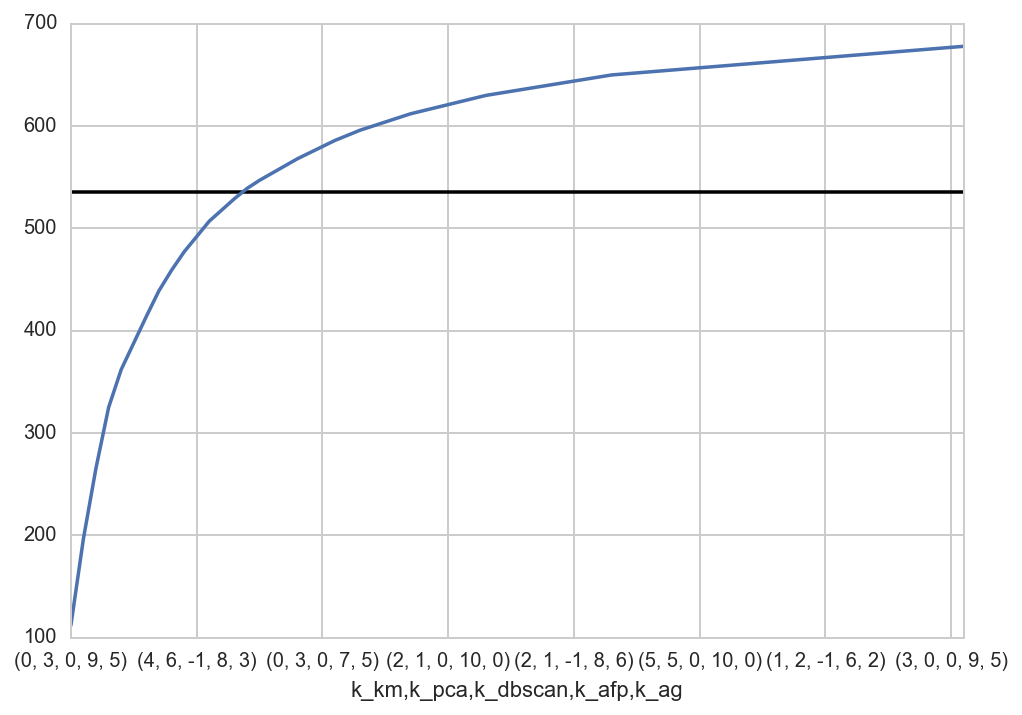

In [6]:
num_cluster_combined = grupo.groupby(['k_km', 'k_pca', 'k_dbscan', 'k_afp', 'k_ag']).ts.count().sort_values(ascending=False)
identif_acum = num_cluster_combined.cumsum()
principales = num_cluster_combined[identif_acum < len(grupo) // 10 * 8]

print_cyan(principales)
ax = identif_acum.plot()
ax.hlines([len(grupo) // 10 * 8], 0, 100)

idx_comb_i = grupo.set_index(principales.index.names).sort_index().loc[principales.index[0], 'ts']
eventos.loc[pd.DatetimeIndex(idx_comb_i.reset_index(drop=True), tz=TZ)].head()

In [3]:
homog = LDR.resample('1s').mean().fillna(-1).astype(int)
homog['median_filter'] = medfilt(homog.ldr, kernel_size=7)
homog.head(10)

ldr  median_filter
ts                                           
2016-08-12 10:46:25+02:00  661            0.0
2016-08-12 10:46:26+02:00   -1          658.0
2016-08-12 10:46:27+02:00  660          658.0
2016-08-12 10:46:28+02:00  659          658.0
2016-08-12 10:46:29+02:00  658          657.0
2016-08-12 10:46:30+02:00  657          657.0
2016-08-12 10:46:31+02:00  657          657.0
2016-08-12 10:46:32+02:00  657          657.0
2016-08-12 10:46:33+02:00  657          657.0
2016-08-12 10:46:34+02:00  656          656.0

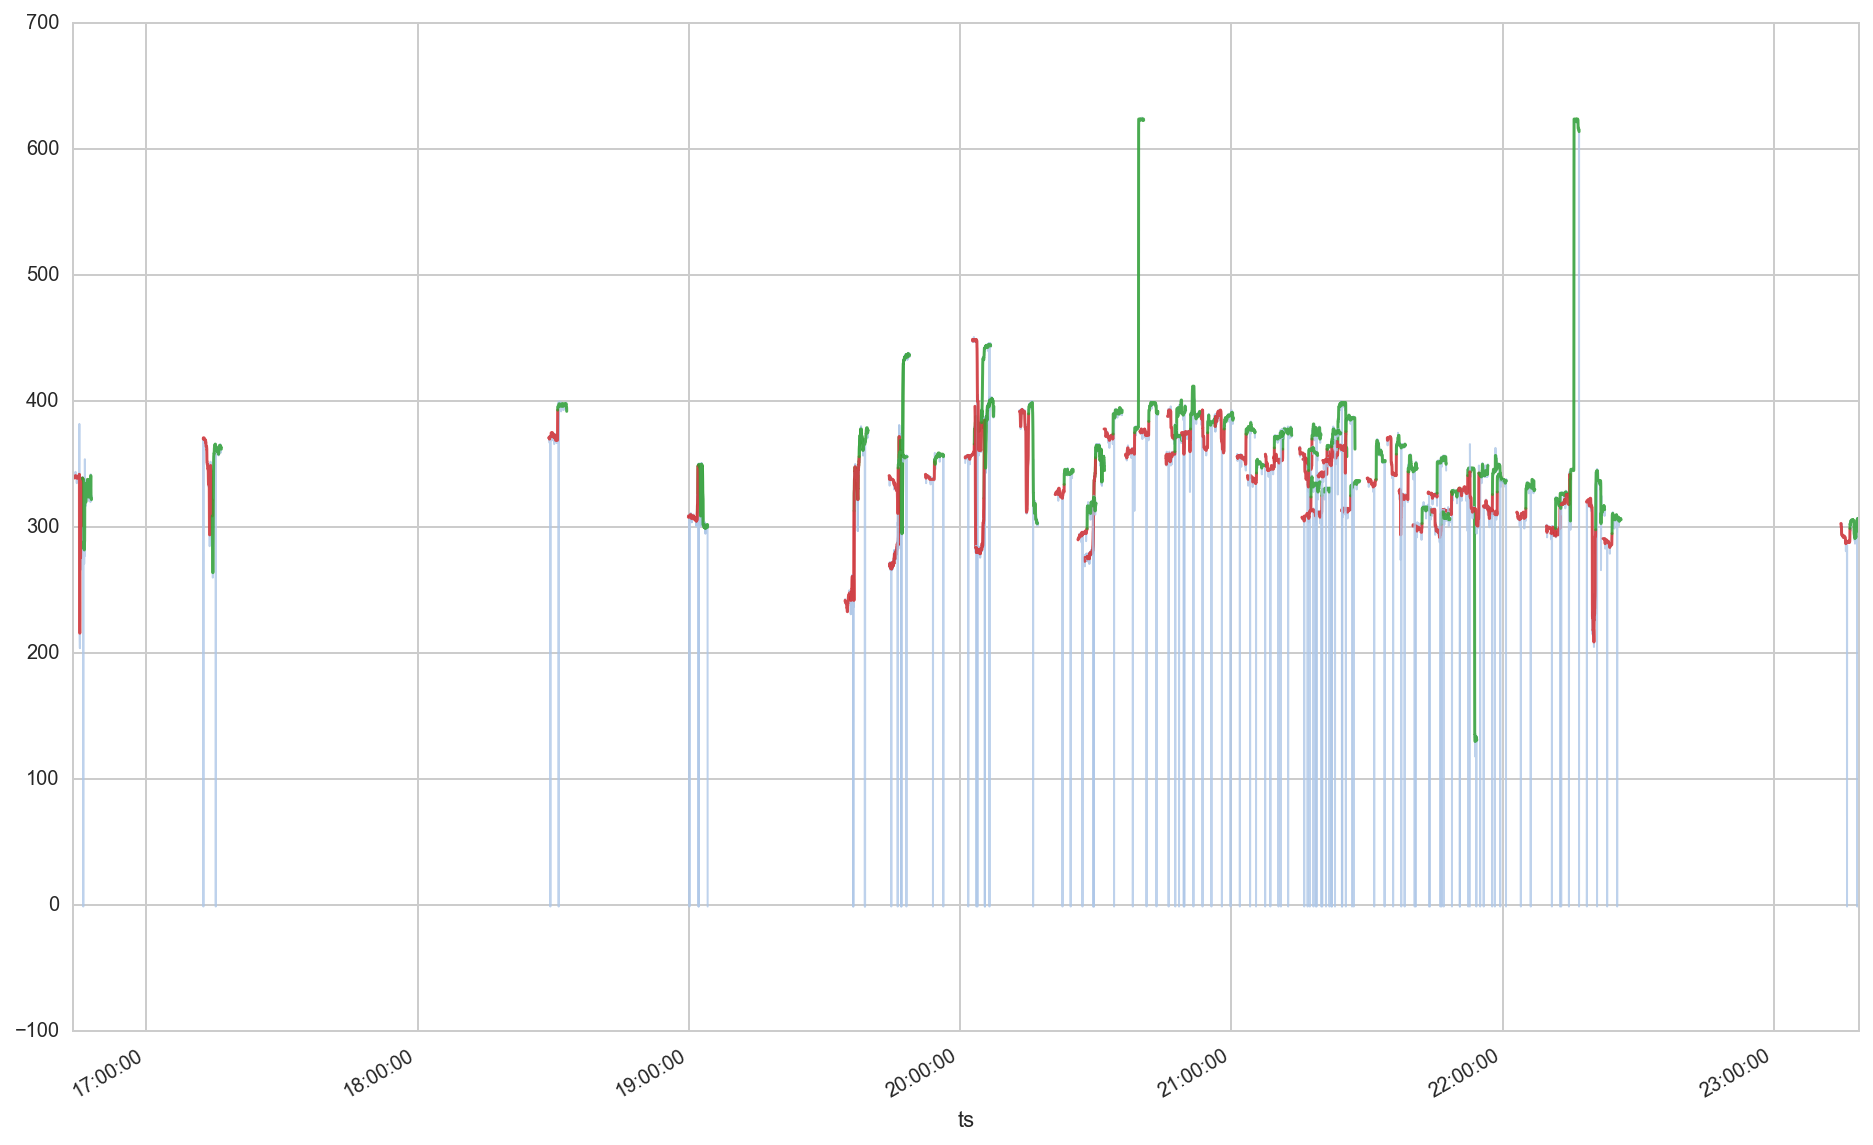

In [7]:
def plot_events_on_day(eventos, data_ldr_mf):
    delta = pd.Timedelta('2min')
    delta_big = pd.Timedelta('10min')
    ax, day_plot = None, None
    for t, row in eventos.iterrows():
        #print_secc(str(t))
        roundings = data_ldr_mf.loc[t-delta:t+delta].copy()
        roundings_big = data_ldr_mf.loc[t-delta_big:t+delta_big].copy()
        if not roundings.empty:
            if ax is None:
                day_plot = t.date()
            else:
                t = dt.datetime.combine(day_plot, t.time())
                new_index = pd.DatetimeIndex([dt.datetime.combine(day_plot, t) for t in roundings.index.time])
                new_index_big = pd.DatetimeIndex([dt.datetime.combine(day_plot, t) for t in roundings_big.index.time])
                roundings.index = new_index
                roundings_big.index = new_index_big
            if ax is None:
                ax = roundings['ldr'].plot(figsize=FS, lw=1, alpha=.8, color=tableau20[1])
            else:
                roundings['ldr'].plot(ax=ax, lw=1, alpha=.8, color=tableau20[1])
            ini = roundings['median_filter'].loc[:t]
            fin = roundings['median_filter'].loc[t:]
            if not ini.empty:
                ini.plot(ax=ax, lw=1.5, alpha=.8, color=tableau20[6])
            else:
                print_magenta('No hay INIT')
            if not fin.empty:
                fin.plot(ax=ax, lw=1.5, alpha=.8, color=tableau20[4])
            else:
                print_red('No hay FIN')
            #ax.vlines([t], 0, 800, lw=1, linestyle='--', alpha=.6)
            #roundings_big.ldr.plot(ax=ax, lw=.5, alpha=.5, color=tableau20[1])
    plt.show()



idx_comb_i = grupo.set_index(principales.index.names).sort_index().loc[principales.index[3], 'ts']
plot_events_on_day(eventos.loc[pd.DatetimeIndex(idx_comb_i.reset_index(drop=True), tz=TZ)], homog)

In [179]:
principales.index[3]

(5, 0, 0, 7, 0)

In [181]:
homog['es_evento'] = False
homog.loc[eventos.index, 'es_evento'] = True
homog.head(10)

ldr  median_filter es_evento
ts                                                     
2016-08-12 10:46:25+02:00  661            0.0     False
2016-08-12 10:46:26+02:00   -1          658.0     False
2016-08-12 10:46:27+02:00  660          658.0     False
2016-08-12 10:46:28+02:00  659          658.0     False
2016-08-12 10:46:29+02:00  658          657.0     False
2016-08-12 10:46:30+02:00  657          657.0     False
2016-08-12 10:46:31+02:00  657          657.0     False
2016-08-12 10:46:32+02:00  657          657.0     False
2016-08-12 10:46:33+02:00  657          657.0     False
2016-08-12 10:46:34+02:00  656          656.0     False

In [6]:
import statsmodels.api as sm

data_stats = homog.loc[eventos.index[0]:eventos.index[-1]].iloc[1:-1]
data_stats
#sm.tsa.acf(data_stats.median_filter, nlags=60)

(2855834, 2)

In [31]:
#def ewma_outlier(tsdf, stdlimit=5, span=15) :

# EWMA:
tsdf = data_stats.iloc[:10000].copy()
tsdf.loc[tsdf.ldr == -1, 'ldr'] = np.nan
stdlimit = 5
span = 7

ewm = tsdf['ldr'].ewm(adjust=True,ignore_na=True,min_periods=3,span=5)
tsdf['ldr_binpred'] = ewm.mean().shift(-1)
tsdf['ldr_binstd'] = ewm.std().shift(-1)
tsdf['ldr_stds'] = ((tsdf['ldr'] - tsdf['ldr_binpred']) / tsdf['ldr_binstd'])
tsdf['ldr_outlier'] = (tsdf['ldr_stds'].abs() > stdlimit)
tsdf.head(20)

ldr  median_filter  ldr_binpred  ldr_binstd  ldr_stds ldr_outlier
ts                                                                                            
2016-08-12 11:42:40+02:00  616.0          616.0          NaN         NaN       NaN       False
2016-08-12 11:42:41+02:00  611.0          611.0   611.578947    2.924488 -0.197965       False
2016-08-12 11:42:42+02:00  610.0          611.0   611.338462    2.148816 -0.622883       False
2016-08-12 11:42:43+02:00  611.0          610.0   610.440758    2.109213  0.265142       False
2016-08-12 11:42:44+02:00  609.0          609.0   608.087218    3.920855  0.232802       False
2016-08-12 11:42:45+02:00  604.0          604.0   602.745508    8.770131  0.143041       False
2016-08-12 11:42:46+02:00  593.0          593.0   593.121491   16.498555 -0.007364       False
2016-08-12 11:42:47+02:00  575.0          575.0   581.443900   22.579449 -0.285388       False
2016-08-12 11:42:48+02:00  559.0          559.0   570.777630   24.795965 -0.474982       False
2016-08-12 11:42:49+02:00  550.0          550.0   562.759051   23.773139 -0.536700       False
2016-08-12 11:42:50+02:00  547.0          547.0   554.441931   23.370380 -0.318434       False
2016-08-12 11:42:51+02:00  538.0          538.0   544.577267   24.591285 -0.267463       False
2016-08-12 11:42:52+02:00  525.0          525.0   534.349811   25.743339 -0.363193       False
2016-08-12 11:42:53+02:00  514.0          514.0   523.875955   26.733528 -0.369422       False
2016-08-12 11:42:54+02:00  503.0          503.0   510.897545   29.939369 -0.263785       False
2016-08-12 11:42:55+02:00  485.0          485.0   495.249147   34.766092 -0.294803       False
2016-08-12 11:42:56+02:00  464.0          464.0   480.155885   37.074373 -0.435770       False
2016-08-12 11:42:57+02:00  450.0          450.0   466.097582   37.548582 -0.428713       False
2016-08-12 11:42:58+02:00  438.0          438.0   452.060833   37.843708 -0.371550       False
2016-08-12 11:42:59+02:00  424.0          424.0   438.704545   37.423352 -0.392924       False

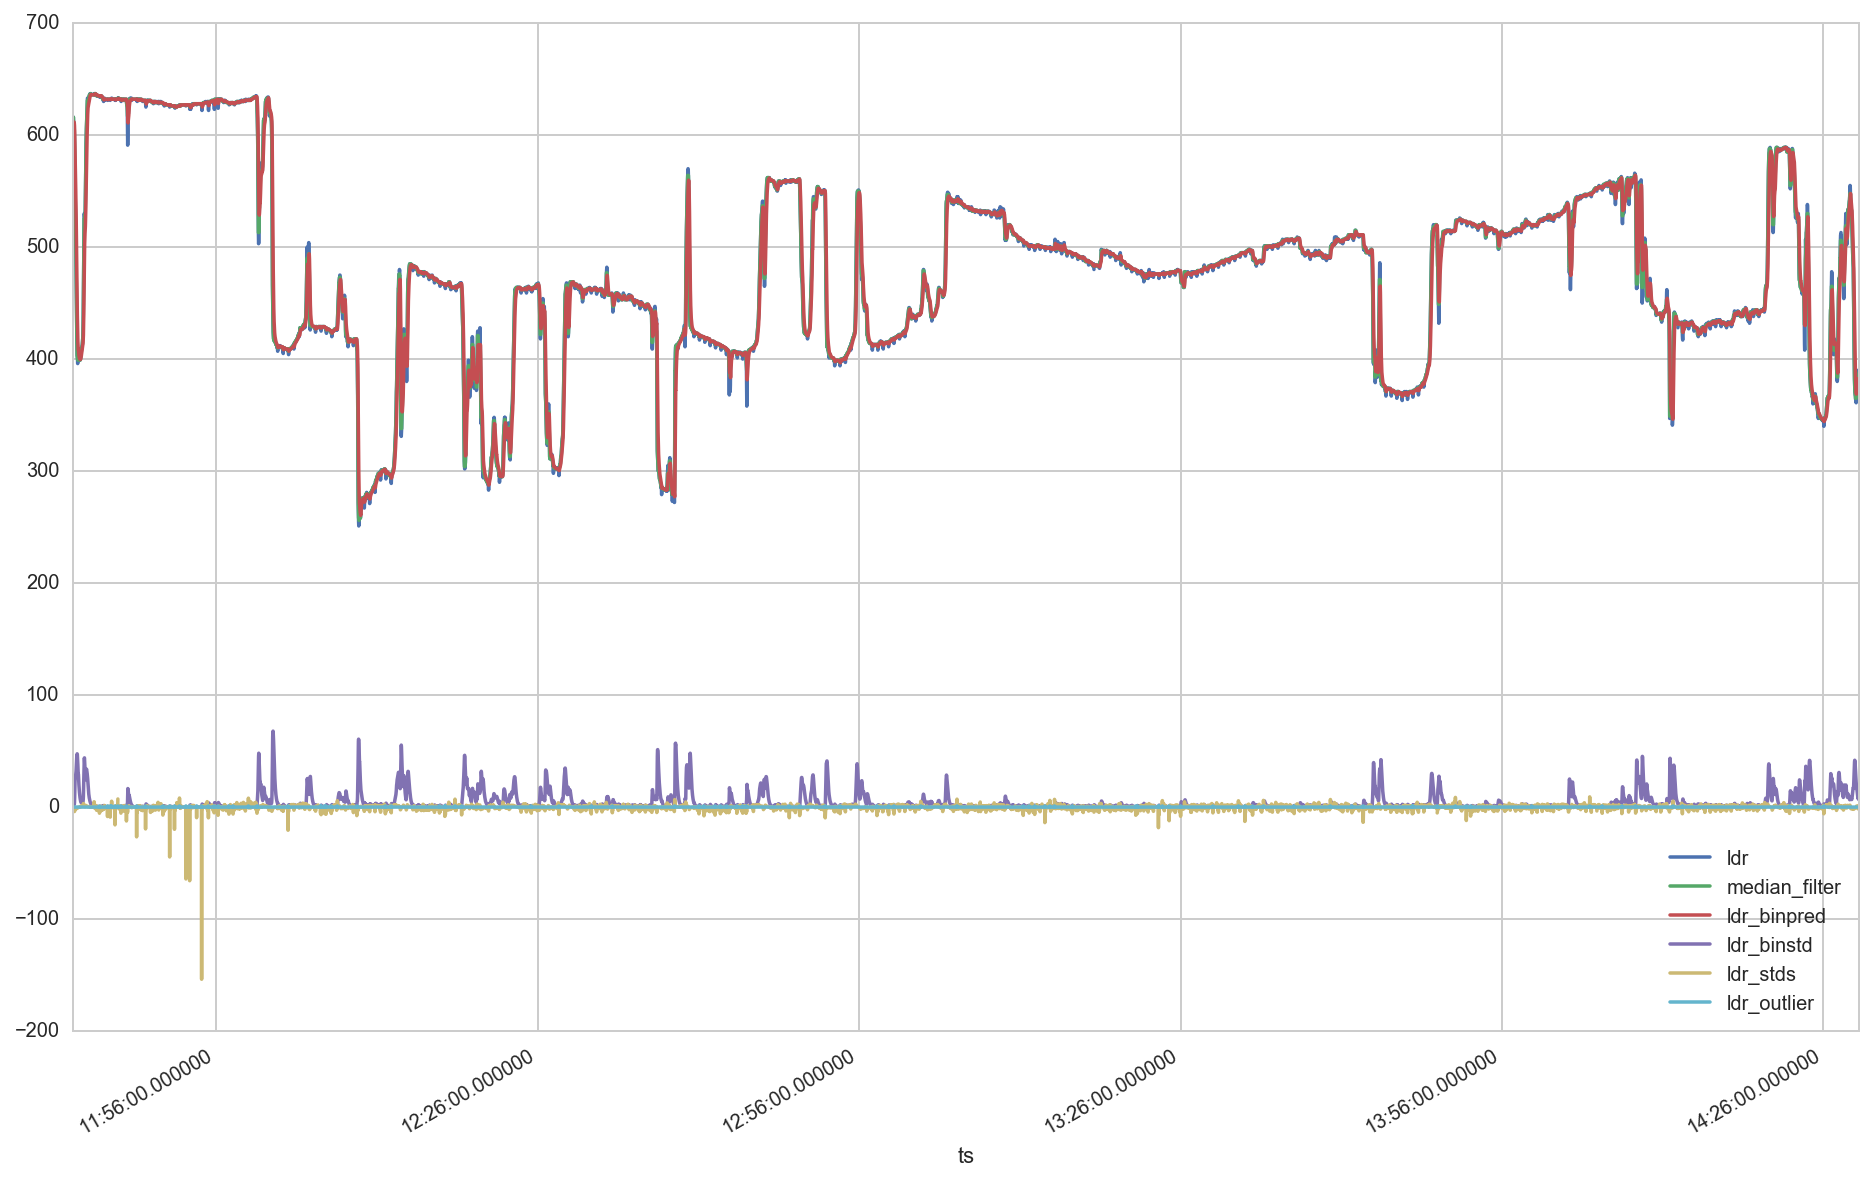

In [21]:
tsdf.plot(figsize=FS)

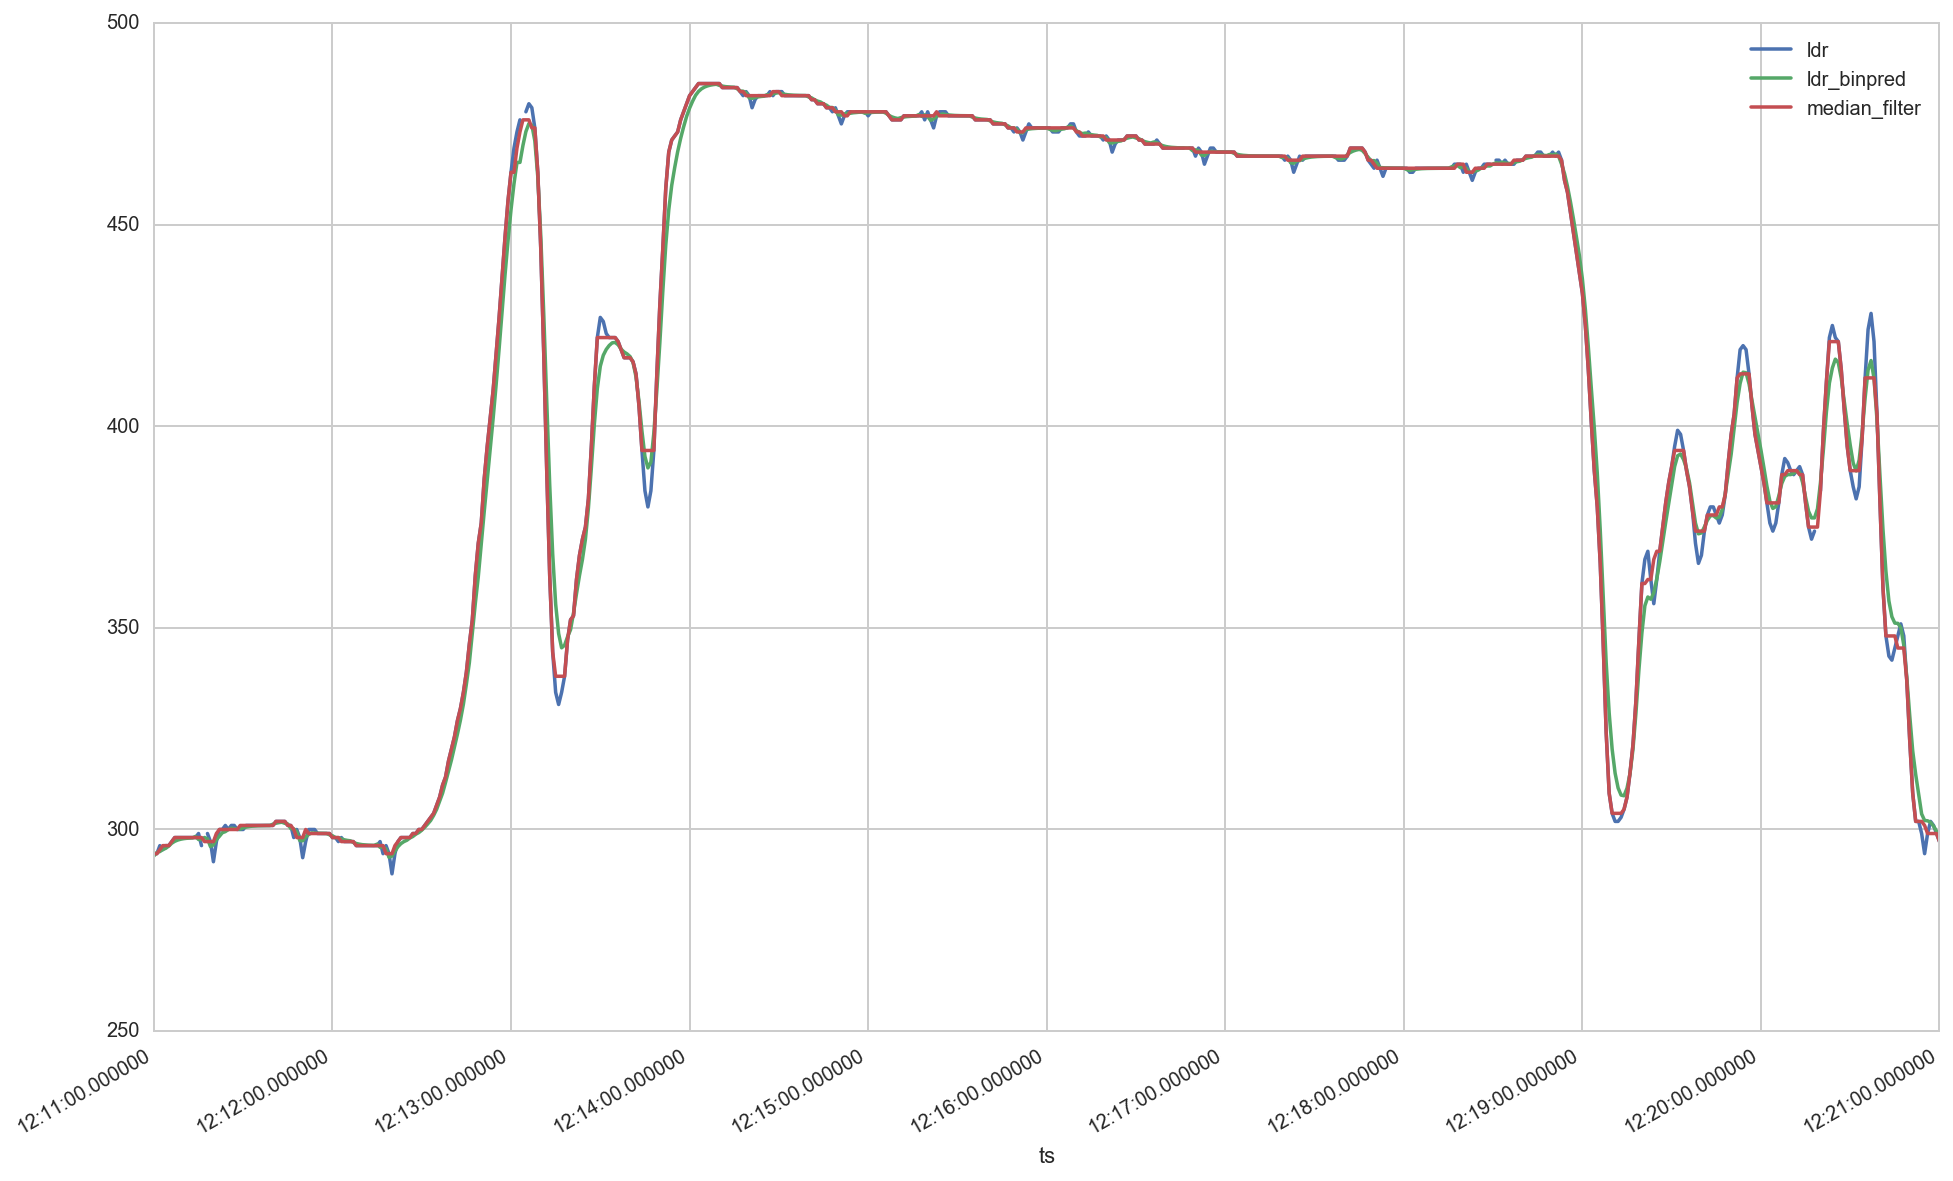

In [32]:
tsdf.between_time('12:11', '12:21')[['ldr', 'ldr_binpred', 'median_filter']].plot(figsize=FS)

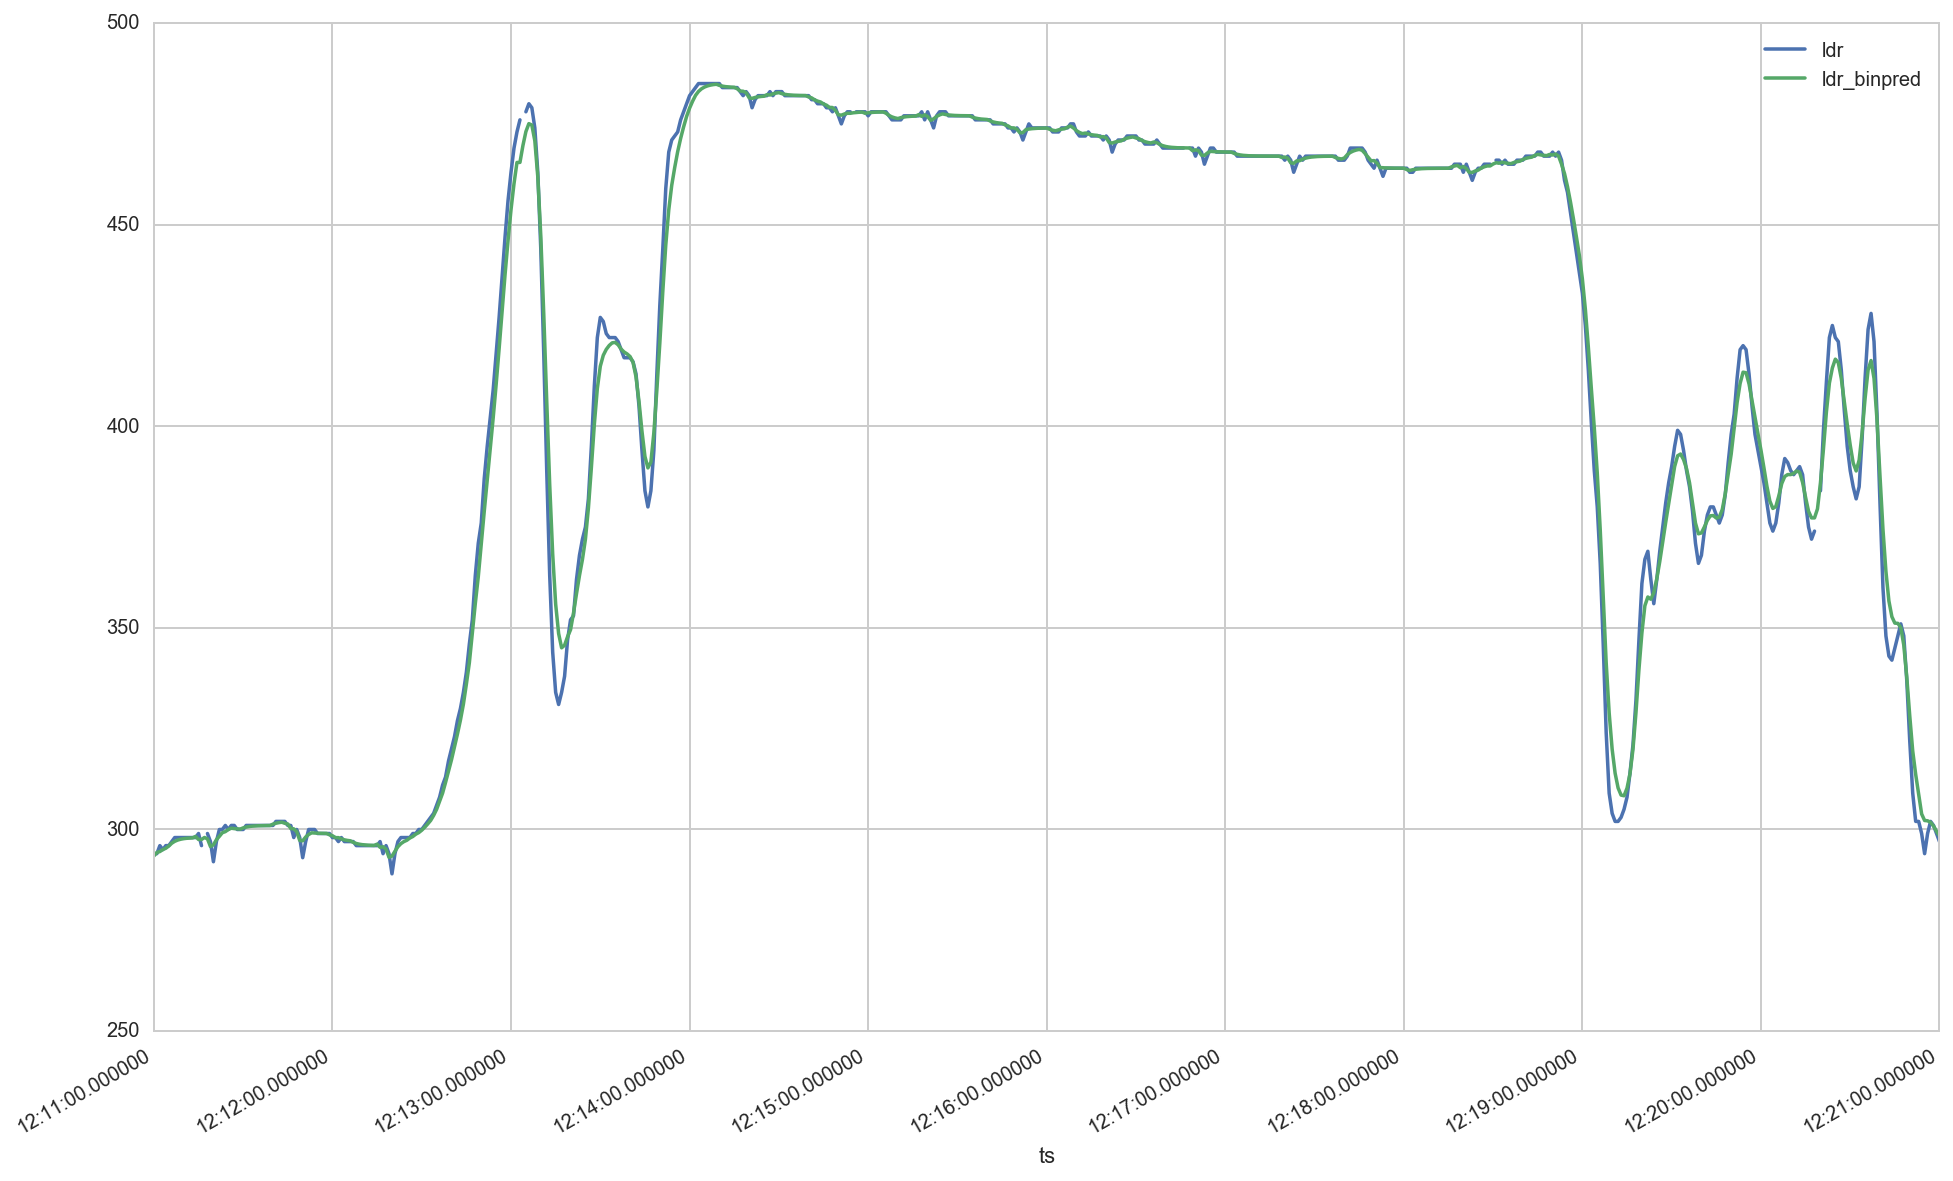

In [33]:
tsdf.between_time('12:11', '12:21')[['ldr', 'ldr_binpred']].plot(figsize=FS)

In [45]:
np.all(np.isnan(np.abs(np.fft.rfft(tsdf.ldr, n=1000))))

True

In [48]:
ldr_min = LDR.ldr.resample('1s').mean().fillna(-1).resample('5min').median()
ldr_min.head()

ts
2016-08-12 10:45:00+02:00    656.0
2016-08-12 10:50:00+02:00    655.0
2016-08-12 10:55:00+02:00    654.0
2016-08-12 11:00:00+02:00    653.0
2016-08-12 11:05:00+02:00    651.0
Freq: 5T, Name: ldr, dtype: float64

In [9]:
ldr_min = LDR.ldr.resample('1s').mean().resample('5min').apply(lambda x: np.nanmedian(x) if np.any(np.isfinite(x)) else np.nan)
ldr_min.head()

ts
2016-08-12 10:45:00+02:00    656.0
2016-08-12 10:50:00+02:00    656.0
2016-08-12 10:55:00+02:00    654.0
2016-08-12 11:00:00+02:00    653.0
2016-08-12 11:05:00+02:00    651.0
Freq: 5T, Name: ldr, dtype: float64

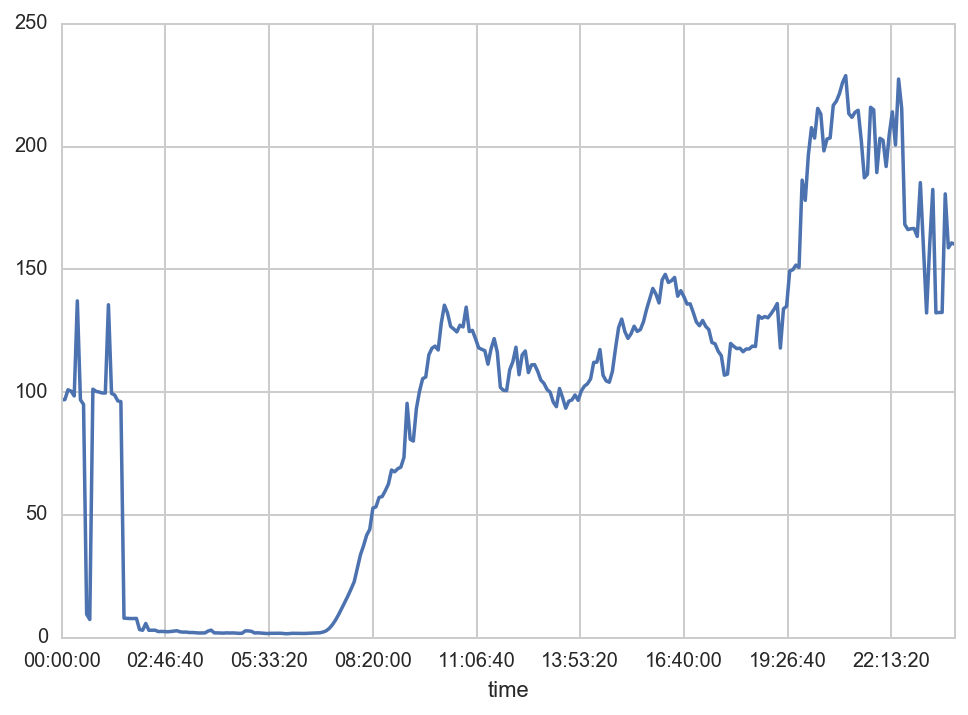

In [11]:
ldr_min.groupby(lambda x: x.time).std().plot()

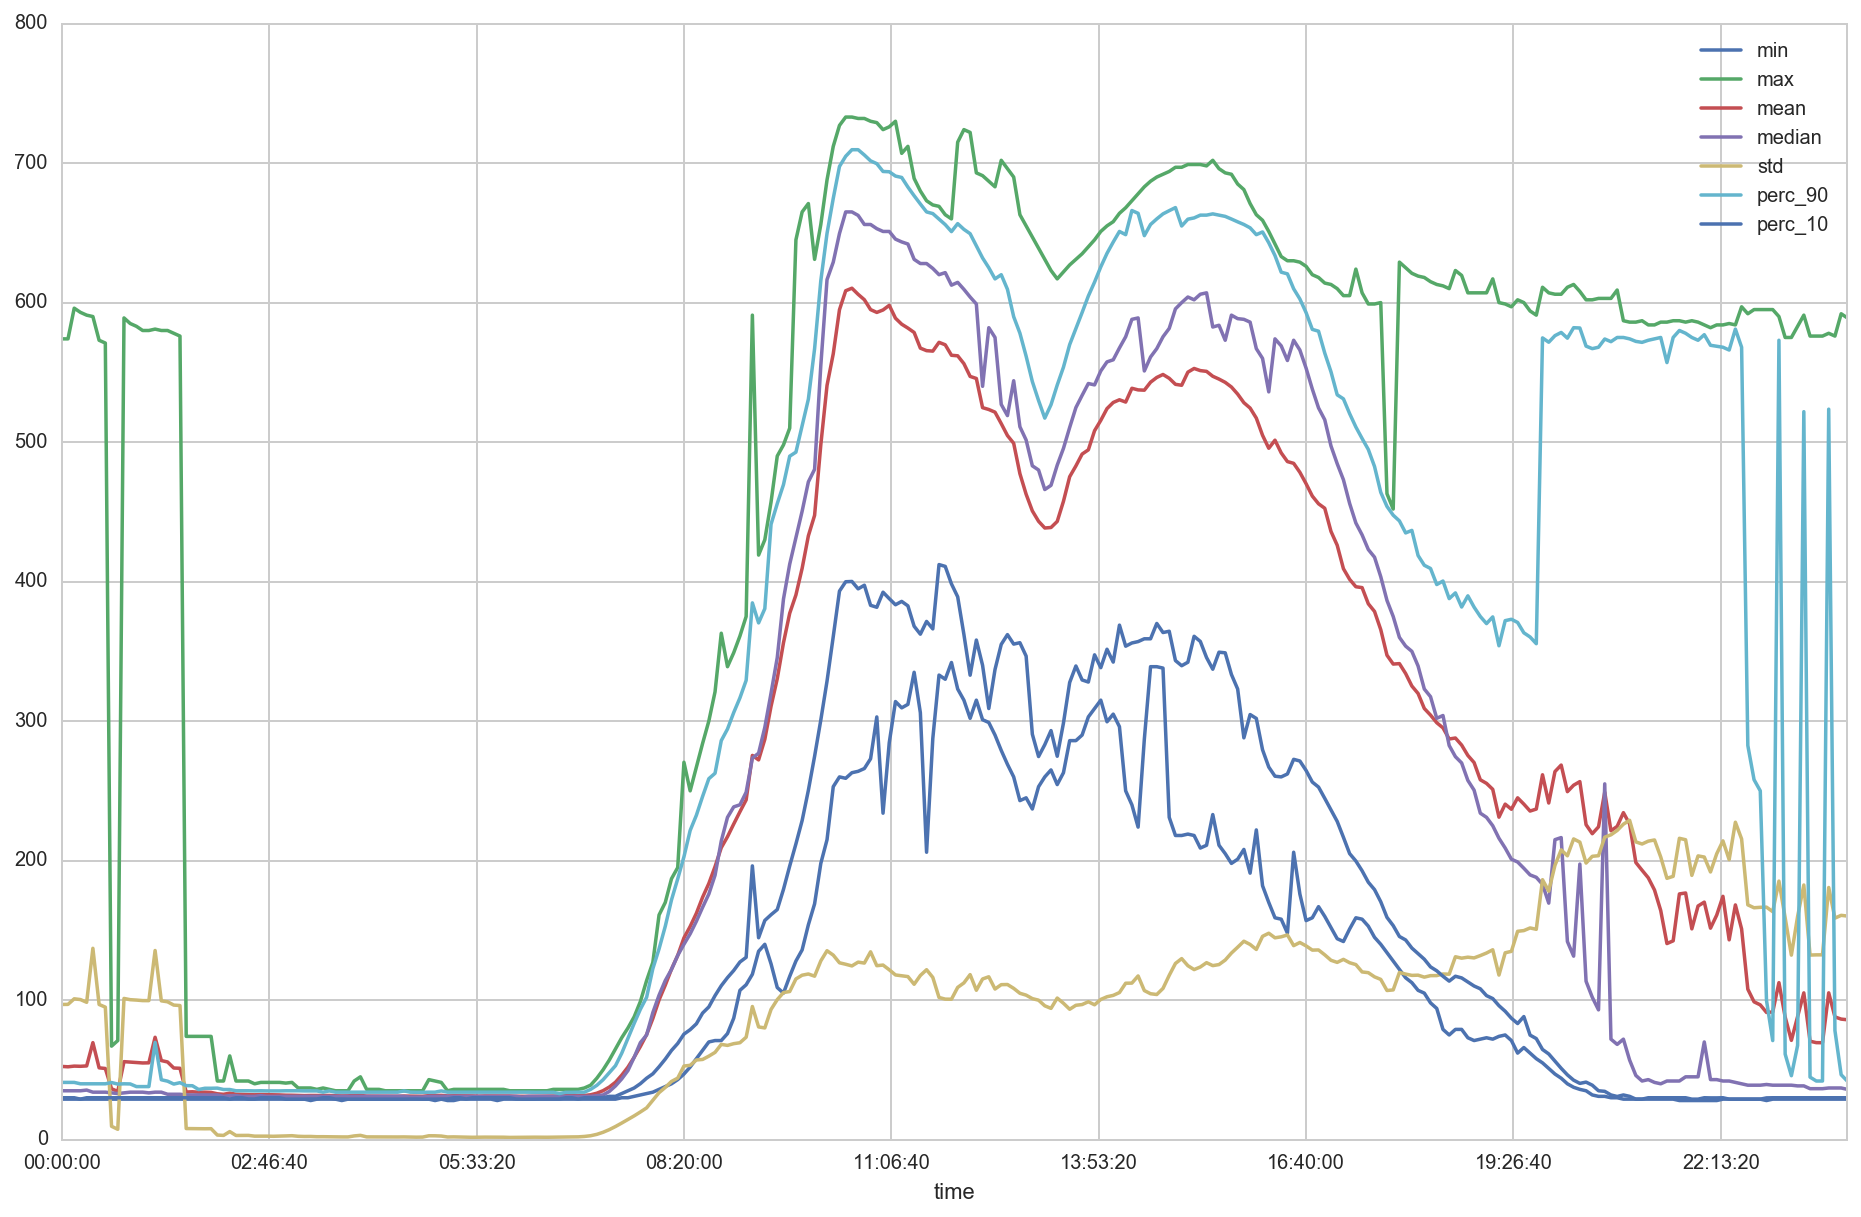

In [59]:
gb_time = ldr_min.groupby(lambda x: x.time)
def _f_perc(y):
    def __perc(x):
        return np.percentile(x[np.isfinite(x)], y) if np.isfinite(x).sum() > 5 else np.nan
    __perc.__name__ = 'perc_{}'.format(y)
    return __perc

#f1 = lambda x: _f_perc(x, 90)
##f1.__name__ = 'perc_90'
#f2 = lambda x: _f_perc(x, 10)
#f2.__name__ = 'perc_10'
typical_day = gb_time.agg(['min', 'max', 'mean', 'median', 'std', 
                           f1, f2])
typical_day.plot(figsize=FS)

In [56]:
plt.fill_between?
#pd.DataFrame(ldr_min).apply(lambda x: x - typical_day.loc[x.index.time, 'median'].values).iloc[:1000].plot()

In [1]:
from enerpi.sunposition import sun_position
sun_position(ldr_min)
#ldr_min

NameError: name 'ldr_min' is not defined

In [63]:
import hdbscan


ldr_min

ts
2016-08-12 10:45:00+02:00    656.0
2016-08-12 10:50:00+02:00    656.0
2016-08-12 10:55:00+02:00    654.0
2016-08-12 11:00:00+02:00    653.0
2016-08-12 11:05:00+02:00    651.0
2016-08-12 11:10:00+02:00    649.0
2016-08-12 11:15:00+02:00    647.0
2016-08-12 11:20:00+02:00    645.0
2016-08-12 11:25:00+02:00    645.0
2016-08-12 11:30:00+02:00    641.0
2016-08-12 11:35:00+02:00    634.0
2016-08-12 11:40:00+02:00    635.0
2016-08-12 11:45:00+02:00    632.0
2016-08-12 11:50:00+02:00    627.0
2016-08-12 11:55:00+02:00    630.0
2016-08-12 12:00:00+02:00    426.0
2016-08-12 12:05:00+02:00    426.0
2016-08-12 12:10:00+02:00    302.0
2016-08-12 12:15:00+02:00    467.0
2016-08-12 12:20:00+02:00    342.0
2016-08-12 12:25:00+02:00    450.0
2016-08-12 12:30:00+02:00    458.0
2016-08-12 12:35:00+02:00    421.0
2016-08-12 12:40:00+02:00    415.0
2016-08-12 12:45:00+02:00    552.0
2016-08-12 12:50:00+02:00    425.0
2016-08-12 12:55:00+02:00    417.0
2016-08-12 13:00:00+02:00    448.0
2016-08-12 13:05:

In [77]:
def _step(x):
    __name__ = 'step'
    return x[-1] - x[0]

features = homog.median_filter.iloc[:1000000].resample('1min').agg(['min', 'max', 'median', 'std', _step])
print_cyan(features.head())
f_sol = sun_position(features.index)
features = f_sol.join(features)
features['minuteofday'] = features.index.hour * 60 + features.index.minute
features['dayofyear'] = features.index.dayofyear
features.tail()

                             min    max  median         std  _step
ts                                                                
2016-08-12 10:46:00+02:00   -1.0  658.0   656.0  233.318562   -1.0
2016-08-12 10:47:00+02:00   -1.0  658.0   328.0  331.944664  658.0
2016-08-12 10:48:00+02:00  656.0  657.0   656.0    0.129099   -1.0
2016-08-12 10:49:00+02:00  653.0  656.0   654.0    0.911167   -2.0
2016-08-12 10:50:00+02:00  651.0  654.0   654.0    0.936395   -1.0


altitude     azimuth   min   max  median       std  _step  minuteofday  dayofyear
ts                                                                                                           
2016-08-24 00:29:00+02:00 -35.428864  150.403626  27.0  32.0    31.0  1.344060    0.0           29        237
2016-08-24 00:30:00+02:00 -35.525142  150.680822  26.0  31.0    31.0  1.477133    0.0           30        237
2016-08-24 00:31:00+02:00 -35.620594  150.958783  26.0  31.0    31.0  1.536284    0.0           31        237
2016-08-24 00:32:00+02:00 -35.715216  151.237510  25.0  31.0    31.0  1.580245    0.0           32        237
2016-08-24 00:33:00+02:00 -35.809005  151.516974  31.0  31.0    31.0  0.000000    0.0           33        237

In [79]:
model = hdbscan.HDBSCAN().fit(features)
model

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, core_dist_n_jobs=4, gen_min_span_tree=False,
    leaf_size=40, memory=Memory(cachedir=None), metric='euclidean',
    min_cluster_size=5, min_samples=None, p=None)

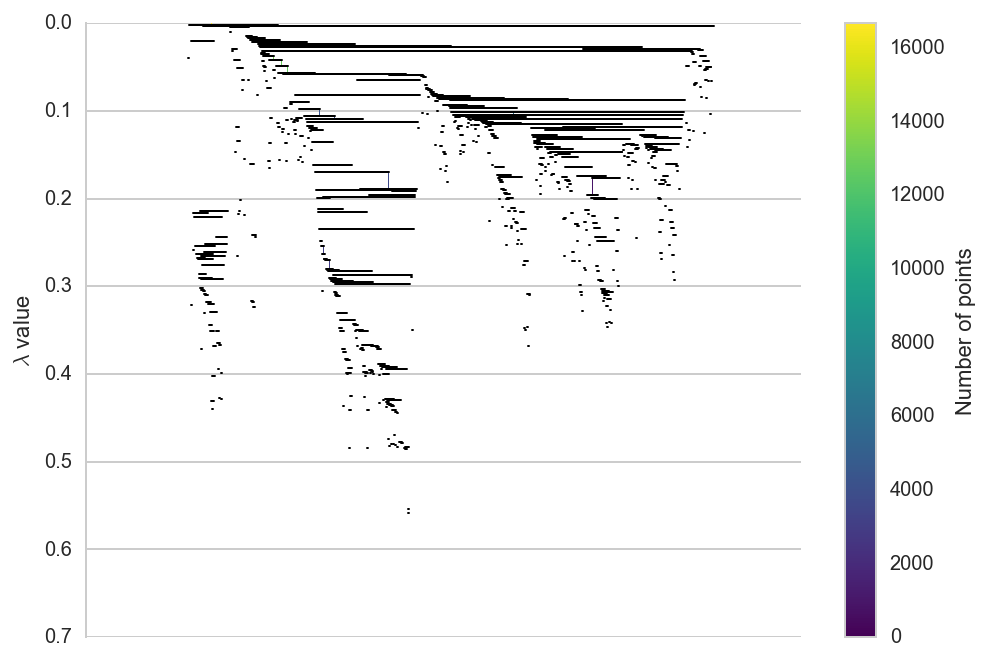

In [81]:
model.condensed_tree_.plot()

/Users/uge/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


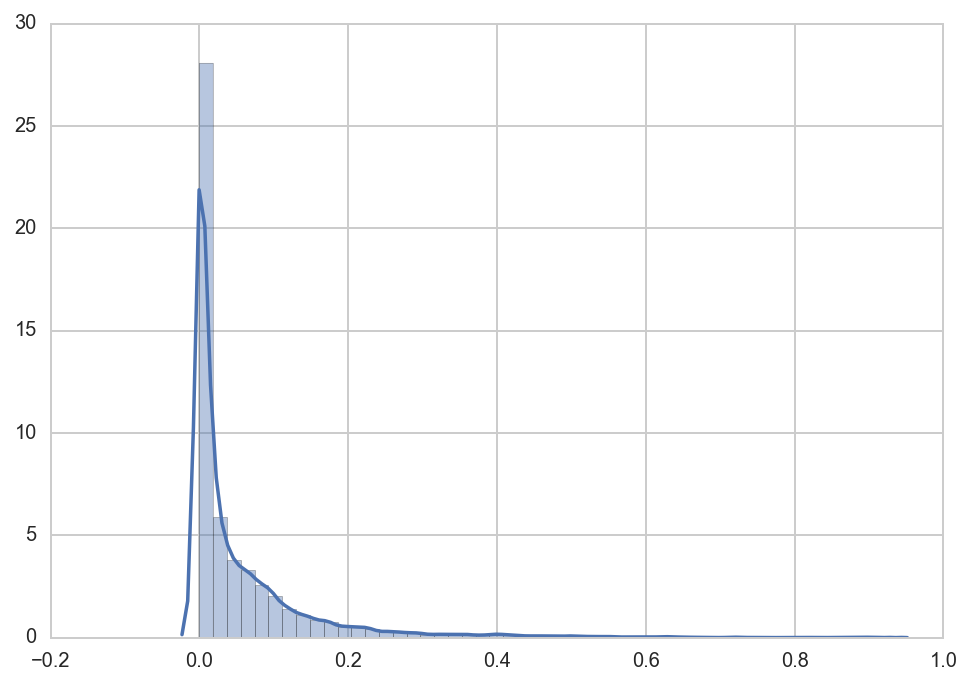

In [83]:
sns.distplot(model.outlier_scores_[np.isfinite(model.outlier_scores_)])

In [84]:
model.outlier_scores_[np.isfinite(model.outlier_scores_)]

array([ 0.3093807 ,  0.22379943,  0.03867117, ...,  0.01148965,
        0.01768995,  0.08133789])

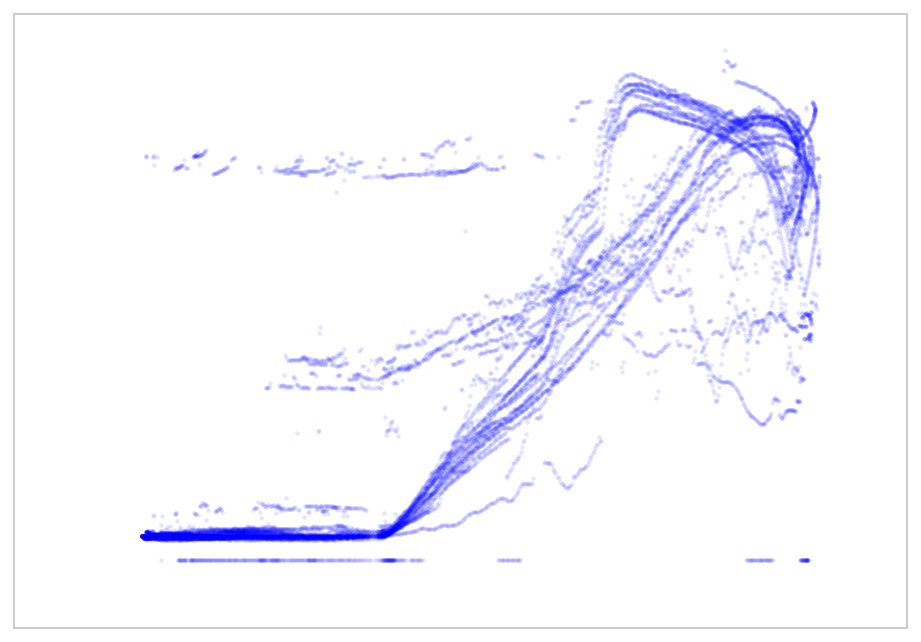

In [94]:
plt.scatter(features.T.ix[0], features.T.ix[3], c='b', lw=0, s=5, alpha=.1)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)

In [103]:
from sklearn.manifold import TSNE
X = features.drop(['min', 'max'], axis=1).values
tsne = TSNE(n_components=2, random_state=0)
#np.set_printoptions(suppress=True)
tsne_reduced = tsne.fit_transform(X)
tsne_reduced[:10]

array([[  1.30982160e+08,   2.50803557e+07],
       [  2.94328709e+07,   4.92886635e+07],
       [  1.03547426e+07,  -7.74192798e+04],
       [  2.93293363e+07,  -1.78001124e+07],
       [  6.96536245e+05,   3.84192842e+06],
       [  7.11628434e+06,  -6.22430751e+05],
       [  7.46185531e+06,   5.28138109e+06],
       [  6.55247459e+07,   2.23949017e+07],
       [  2.65212748e+08,   7.67494978e+06],
       [  1.45916860e+08,   3.76250872e+07]])

In [124]:

#frame = plt.gca()
#frame.axes.get_xaxis().set_visible(False)
#frame.axes.get_yaxis().set_visible(False)

In [101]:
features.corr()

altitude   azimuth       min       max    median       std     _step  minuteofday  dayofyear
altitude     1.000000 -0.012503  0.850954  0.850405  0.851051  0.022836  0.001321     0.386252  -0.072215
azimuth     -0.012503  1.000000  0.035843  0.045389  0.040668  0.055951 -0.017556     0.540687  -0.034865
min          0.850954  0.035843  1.000000  0.987248  0.994077 -0.042512 -0.000487     0.315131  -0.010941
max          0.850405  0.045389  0.987248  1.000000  0.994085  0.112119 -0.001233     0.323431  -0.014805
median       0.851051  0.040668  0.994077  0.994085  1.000000  0.035016 -0.005029     0.318545  -0.012935
std          0.022836  0.055951 -0.042512  0.112119  0.035016  1.000000 -0.045698     0.056644  -0.028044
_step        0.001321 -0.017556 -0.000487 -0.001233 -0.005029 -0.045698  1.000000    -0.015437  -0.000361
minuteofday  0.386252  0.540687  0.315131  0.323431  0.318545  0.056644 -0.015437     1.000000  -0.069810
dayofyear   -0.072215 -0.034865 -0.010941 -0.014805 -0.012935 -0.028044 -0.000361    -0.069810   1.000000

In [212]:
features.head()

altitude    azimuth    min    max  median         std  _step  minuteofday  dayofyear
ts                                                                                                              
2016-08-12 10:46:00+02:00  39.711430 -76.190926   -1.0  658.0   656.0  233.318562   -1.0          646        225
2016-08-12 10:47:00+02:00  39.900770 -75.995521   -1.0  658.0   328.0  331.944664  658.0          647        225
2016-08-12 10:48:00+02:00  40.089949 -75.799303  656.0  657.0   656.0    0.129099   -1.0          648        225
2016-08-12 10:49:00+02:00  40.278964 -75.602273  653.0  656.0   654.0    0.911167   -2.0          649        225
2016-08-12 10:50:00+02:00  40.467812 -75.404416  651.0  654.0   654.0    0.936395   -1.0          650        225

In [168]:
from sklearn.preprocessing import StandardScaler

features_valid = features.drop(['min', 'max', 'minuteofday', 'dayofyear'], axis=1).drop(features.index[features['min'] < 0])
features_valid.loc[features_valid.altitude < -5, 'altitude'] = -5
print_red(features_valid.describe())

X = features_valid.values
X_std = StandardScaler().fit_transform(features_valid)
features_std = pd.DataFrame(X_std, columns=features_valid.columns, index=features_valid.index)
features_std.describe()

           altitude       azimuth        median           std         _step   minuteofday     dayofyear
count  16256.000000  16256.000000  16256.000000  16256.000000  16256.000000  16256.000000  16256.000000
mean      19.464209      0.386808    274.202664      2.987711     -0.064345    724.815637    230.763164
std       25.751859    106.938261    240.523119     13.126513     31.662052    411.117055      3.365742
min       -5.000000   -179.981709     27.000000      0.000000   -563.000000      0.000000    225.000000
25%       -5.000000    -98.707888     35.000000      0.950022     -1.000000    370.000000    228.000000
50%       10.304846      2.192448    229.000000      1.351291      0.000000    732.000000    231.000000
75%       44.189494     98.213242    519.000000      1.799168      1.000000   1076.250000    234.000000
max       66.121340    179.976951    730.000000    277.401361    553.000000   1439.000000    237.000000


altitude       azimuth        median           std         _step   minuteofday     dayofyear
count  1.625600e+04  1.625600e+04  1.625600e+04  1.625600e+04  1.625600e+04  1.625600e+04  1.625600e+04
mean   3.781834e-16 -8.590296e-17 -6.146658e-16  3.332855e-18 -6.204427e-17 -7.477068e-17  1.363994e-13
std    1.000031e+00  1.000031e+00  1.000031e+00  1.000031e+00  1.000031e+00  1.000031e+00  1.000031e+00
min   -9.500270e-01 -1.686712e+00 -1.027803e+00 -2.276159e-01 -1.778005e+01 -1.763094e+00 -1.712354e+00
25%   -9.500270e-01 -9.266818e-01 -9.945407e-01 -1.552394e-01 -2.955220e-02 -8.630791e-01 -8.209927e-01
50%   -3.556887e-01  1.688540e-02 -1.879406e-01 -1.246691e-01  2.032321e-03  1.747576e-02  7.036871e-02
75%    9.601654e-01  9.148217e-01  1.017802e+00 -9.054801e-02  3.361684e-02  8.548543e-01  9.617301e-01
max    1.811852e+00  1.679433e+00  1.895083e+00  2.090594e+01  1.746827e+01  1.737234e+00  1.853091e+00

[[  7.79396690e+08   5.93574991e+08]
 [  2.60908618e+09   8.67096119e+08]
 [  2.00054623e+08   1.40657944e+08]
 [ -4.44121644e+07   8.77604124e+07]
 [ -1.02722929e+08   2.69859072e+08]
 [ -5.01517877e+07   1.64084576e+07]
 [  3.24349944e+08   5.91601679e+07]
 [  1.46952871e+08   2.02462449e+07]
 [ -4.41277019e+07   1.76492424e+07]
 [  1.67422645e+09   3.90217070e+07]]


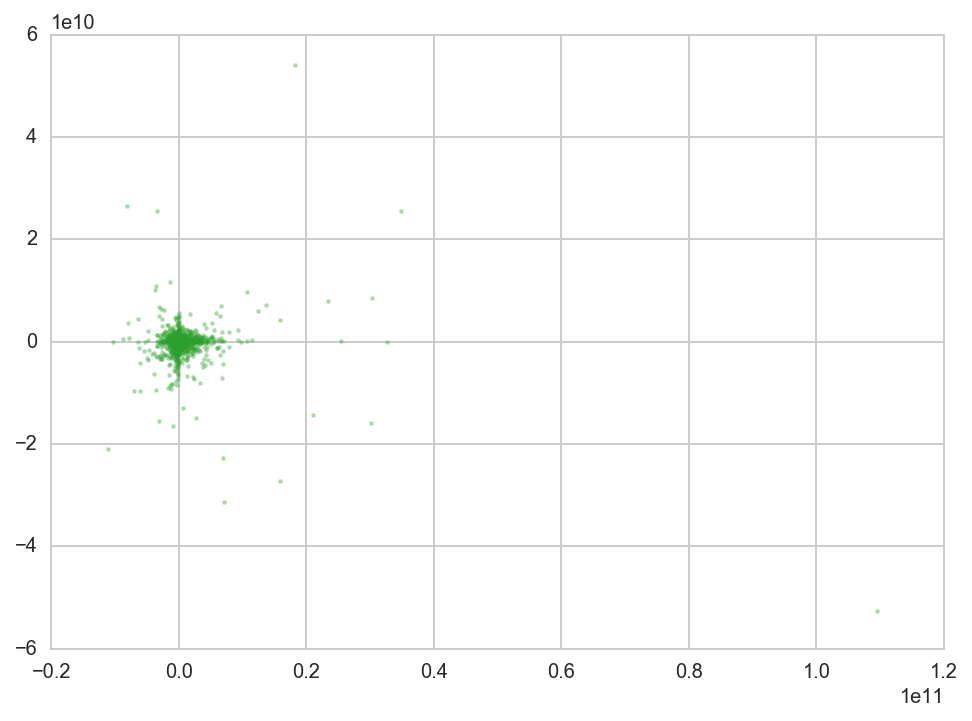

In [125]:
tsne = TSNE(n_components=2, random_state=0)
tsne_reduced = tsne.fit_transform(X_std)
print_red(tsne_reduced[:10])

plt.scatter(tsne_reduced[:,0], tsne_reduced[:,1], c=tableau20[4], lw=0, s=5, alpha=.4)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x159bcdcc0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x159fd8400>], dtype=object)

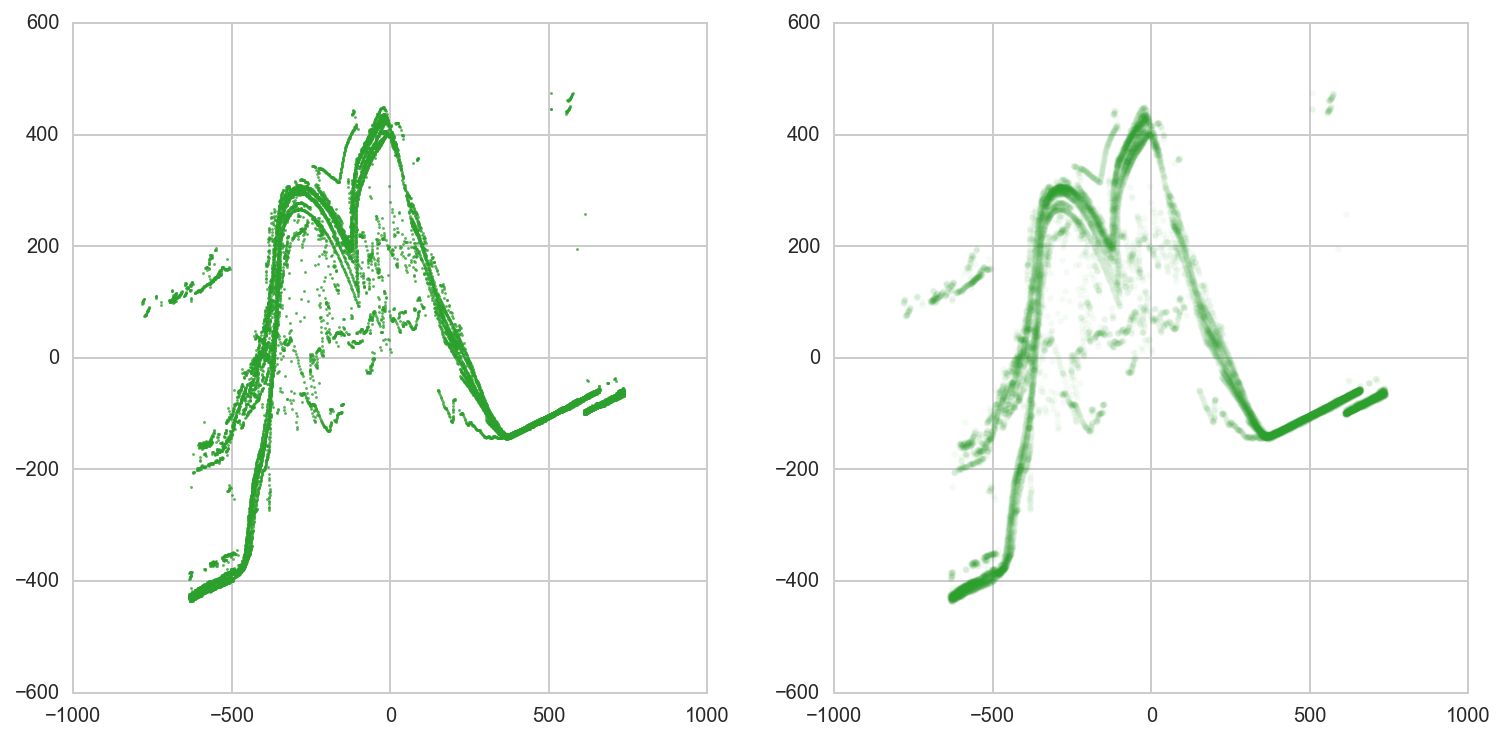

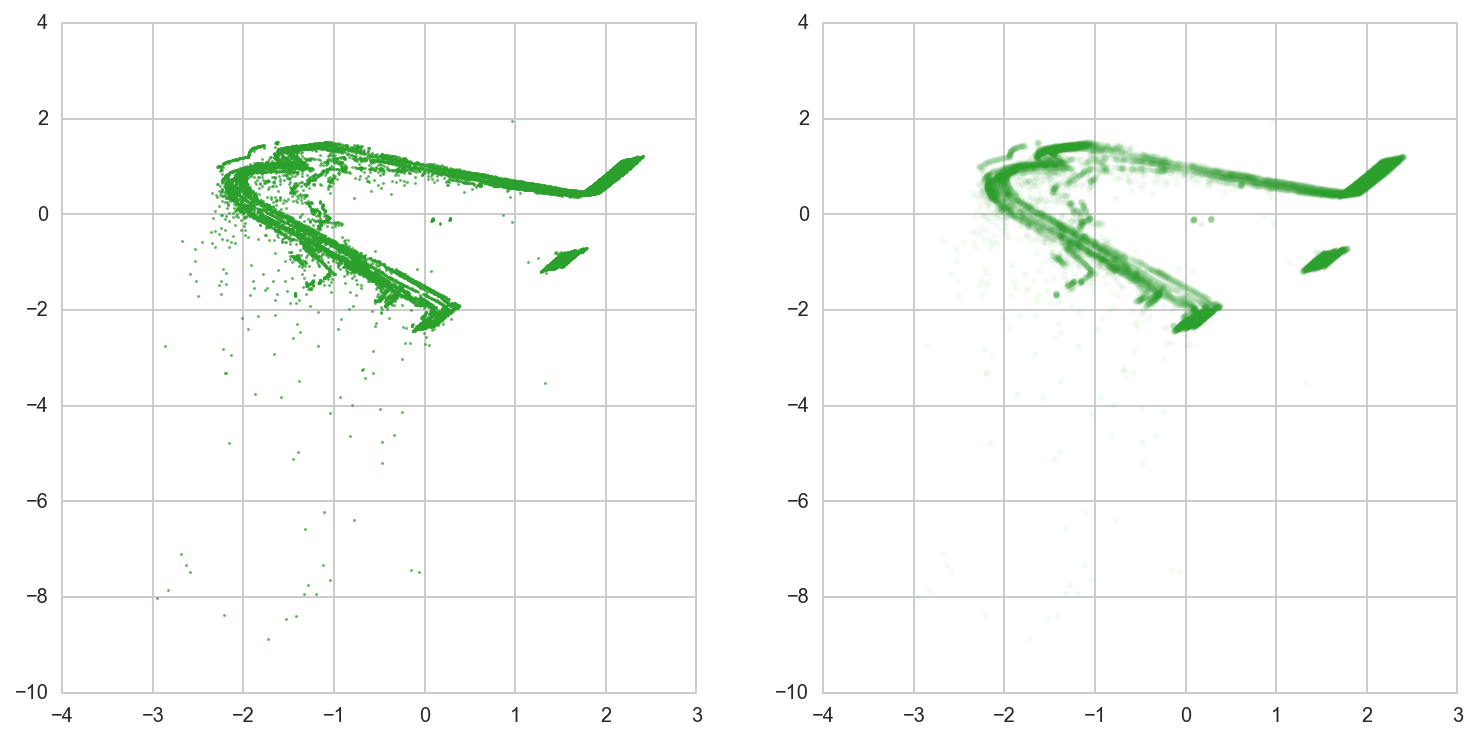

In [208]:
from sklearn.decomposition import PCA, KernelPCA, MiniBatchSparsePCA, IncrementalPCA
from itertools import cycle


def _plot_scatter(x, labels=None):
    cmap_ctableau = cycle(tableau20[::2])
    f, axes = plt.subplots(1, 2, figsize=(12.5, 6))
    if labels is None:
        axes[0].scatter(x[:,0], x[:,1], c=tableau20[4], lw=0, s=2, alpha=.8)
        axes[1].scatter(x[:,0], x[:,1], c=tableau20[4], lw=0, s=10, alpha=.05)
    else:
        for k, col in zip(sorted(set(labels)), cmap_ctableau):
            mask = labels == k
            axes[0].scatter(x[mask,0], x[mask,1], c=col, lw=0, s=2, alpha=.8)
            axes[1].scatter(x[mask,0], x[mask,1], c=col, lw=0, s=10, alpha=.05)
    return axes


X_pca = PCA(n_components=2).fit_transform(X)
_plot_scatter(X_pca)

X_pca_std = PCA(n_components=2).fit_transform(X_std)
_plot_scatter(X_pca_std)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x153b89588>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1557a6ac8>], dtype=object)

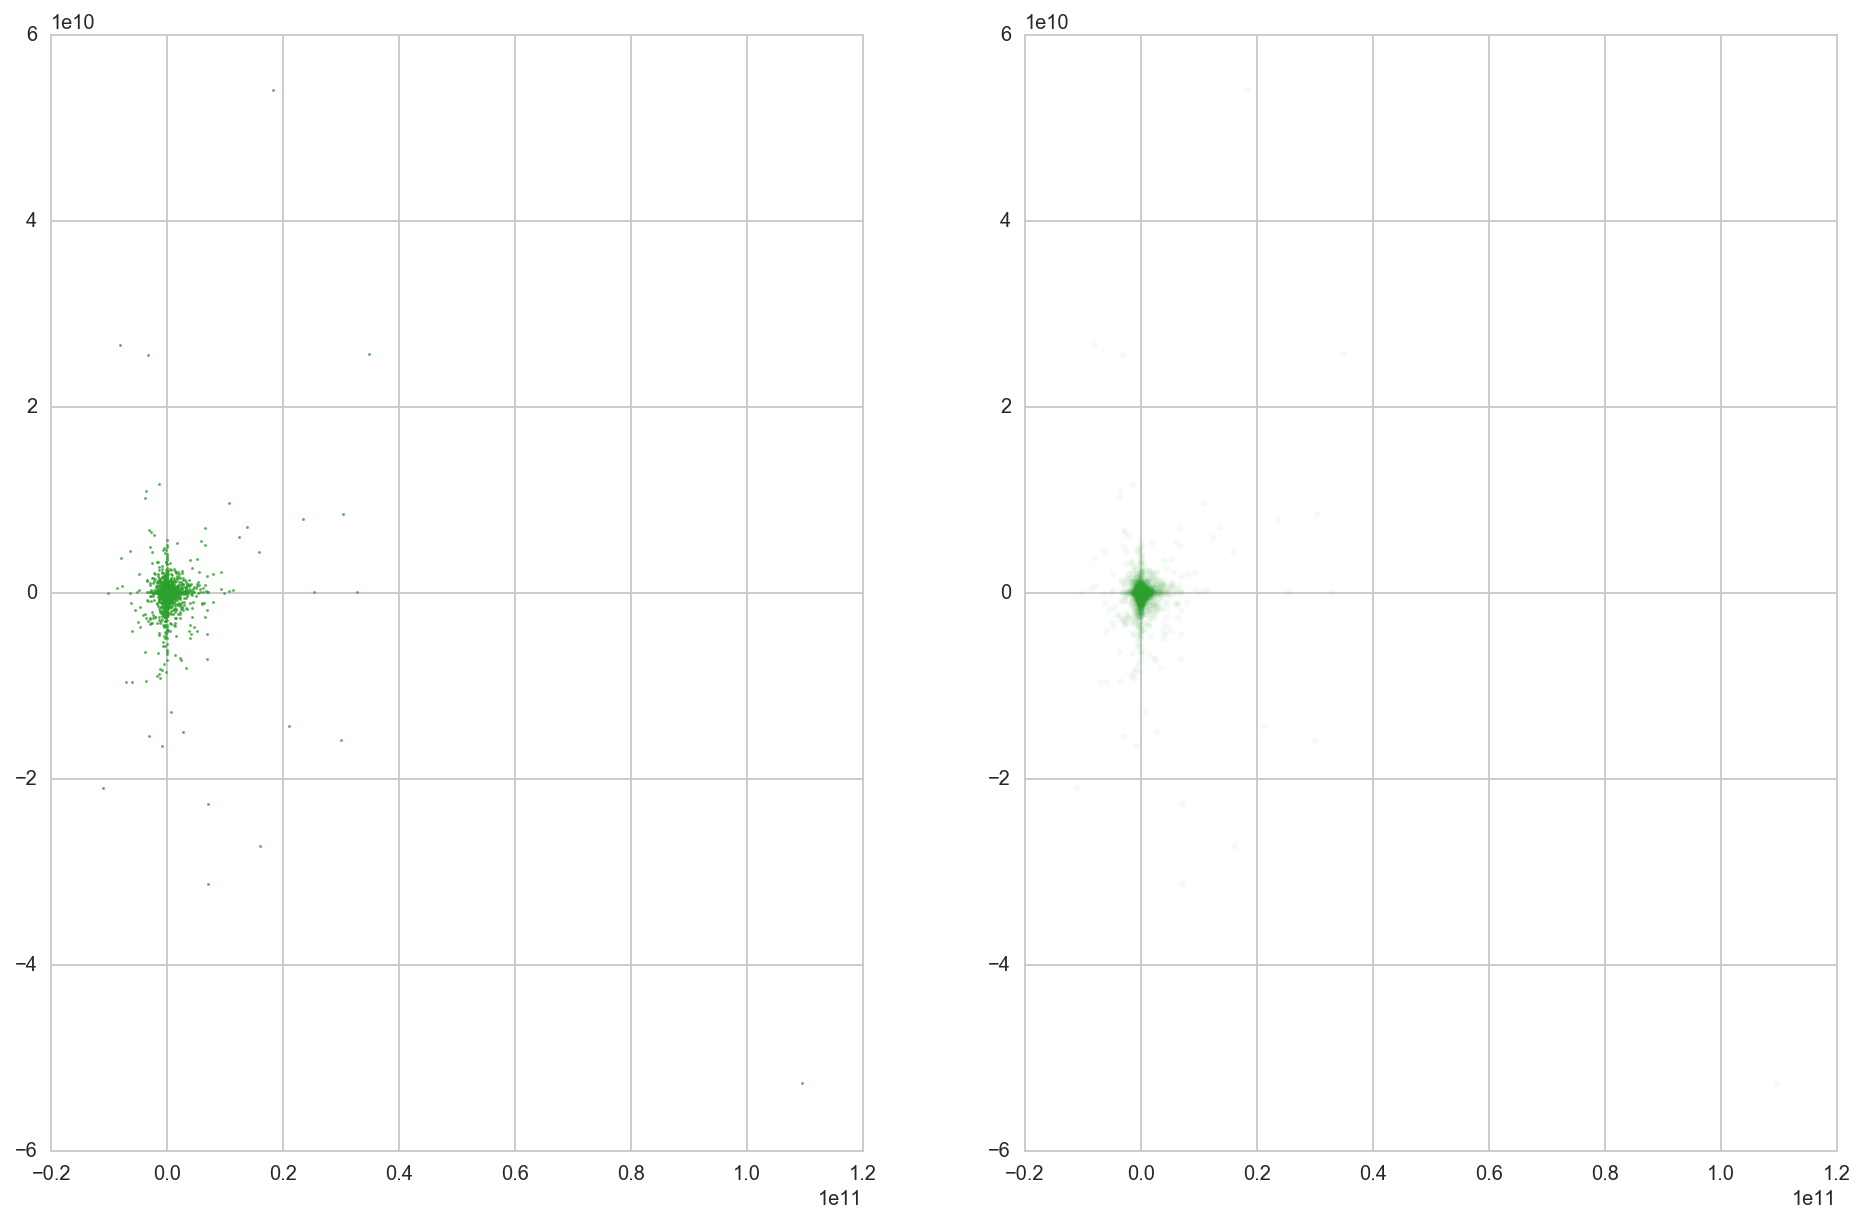

In [138]:
_plot_scatter(tsne_reduced)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x15252c048>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1528bb240>], dtype=object)

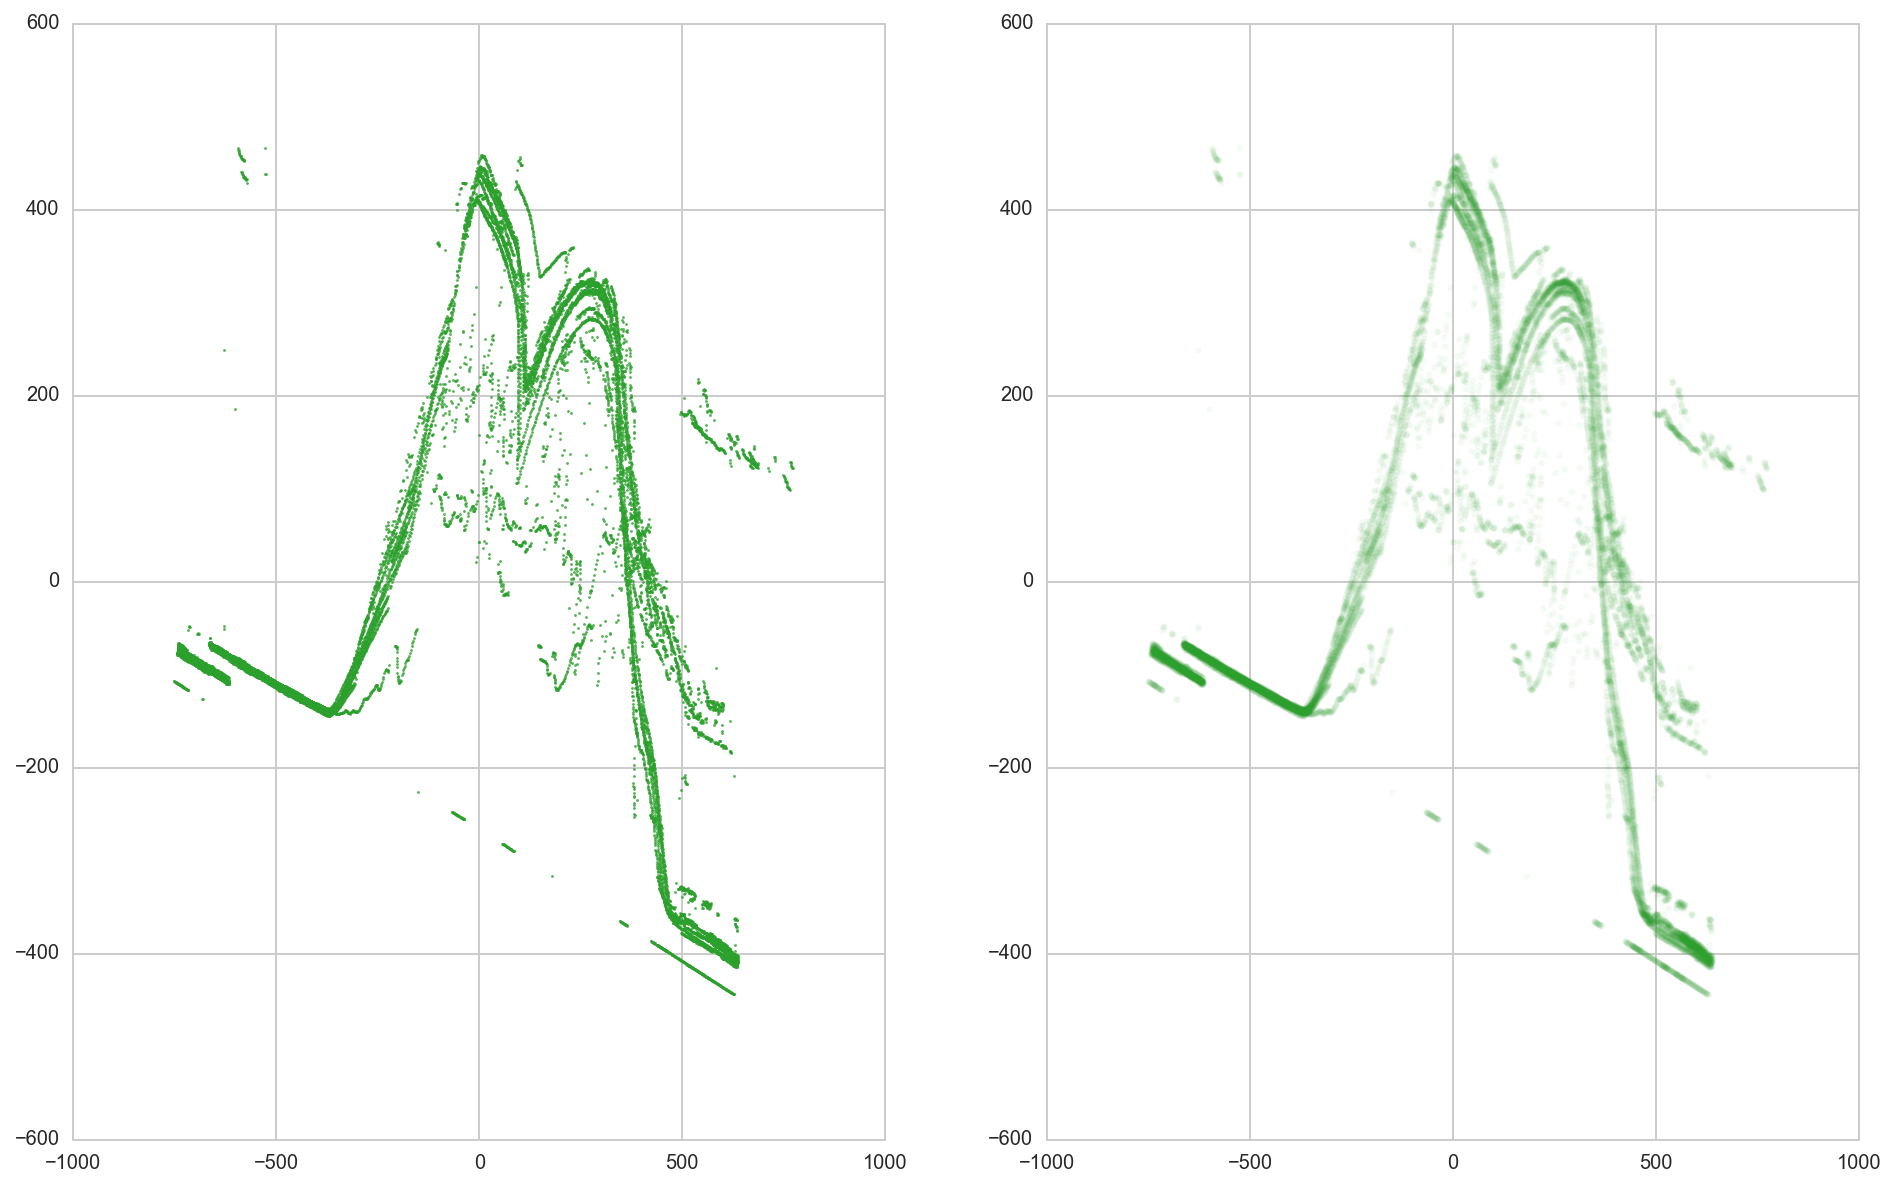

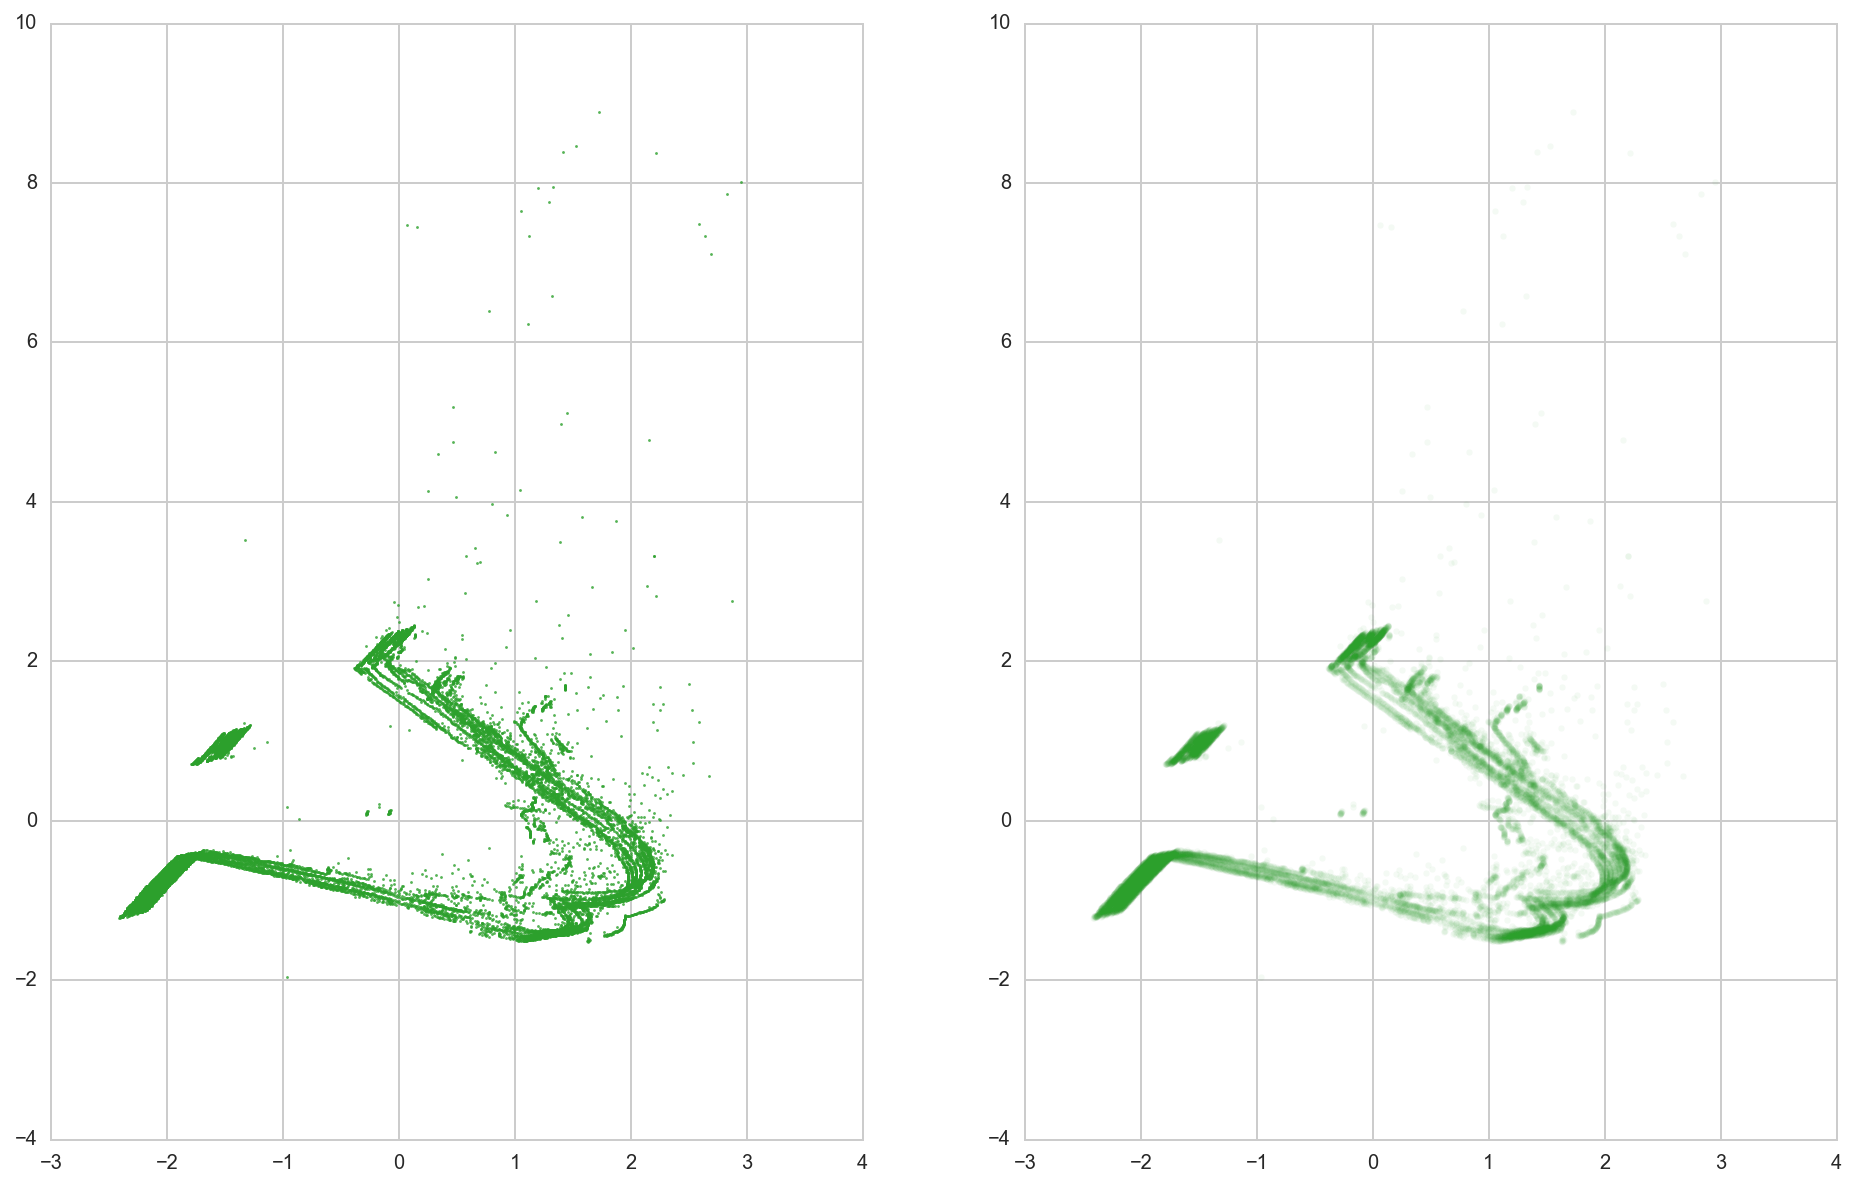

In [139]:
X_kpca = KernelPCA(n_components=2).fit_transform(X)
_plot_scatter(X_kpca)

X_kpca_std = KernelPCA(n_components=2).fit_transform(X_std)
_plot_scatter(X_kpca_std)

In [149]:
from hdbscan import HDBSCAN

clusterer_hdbscan = HDBSCAN(min_cluster_size=60, min_samples=20).fit(X_std)
print_red(len(set(clusterer_hdbscan.labels_)))
clusterer_hdbscan

75


HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, core_dist_n_jobs=4, gen_min_span_tree=False,
    leaf_size=40, memory=Memory(cachedir=None), metric='euclidean',
    min_cluster_size=60, min_samples=20, p=None)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1546faf98>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1547794e0>], dtype=object)

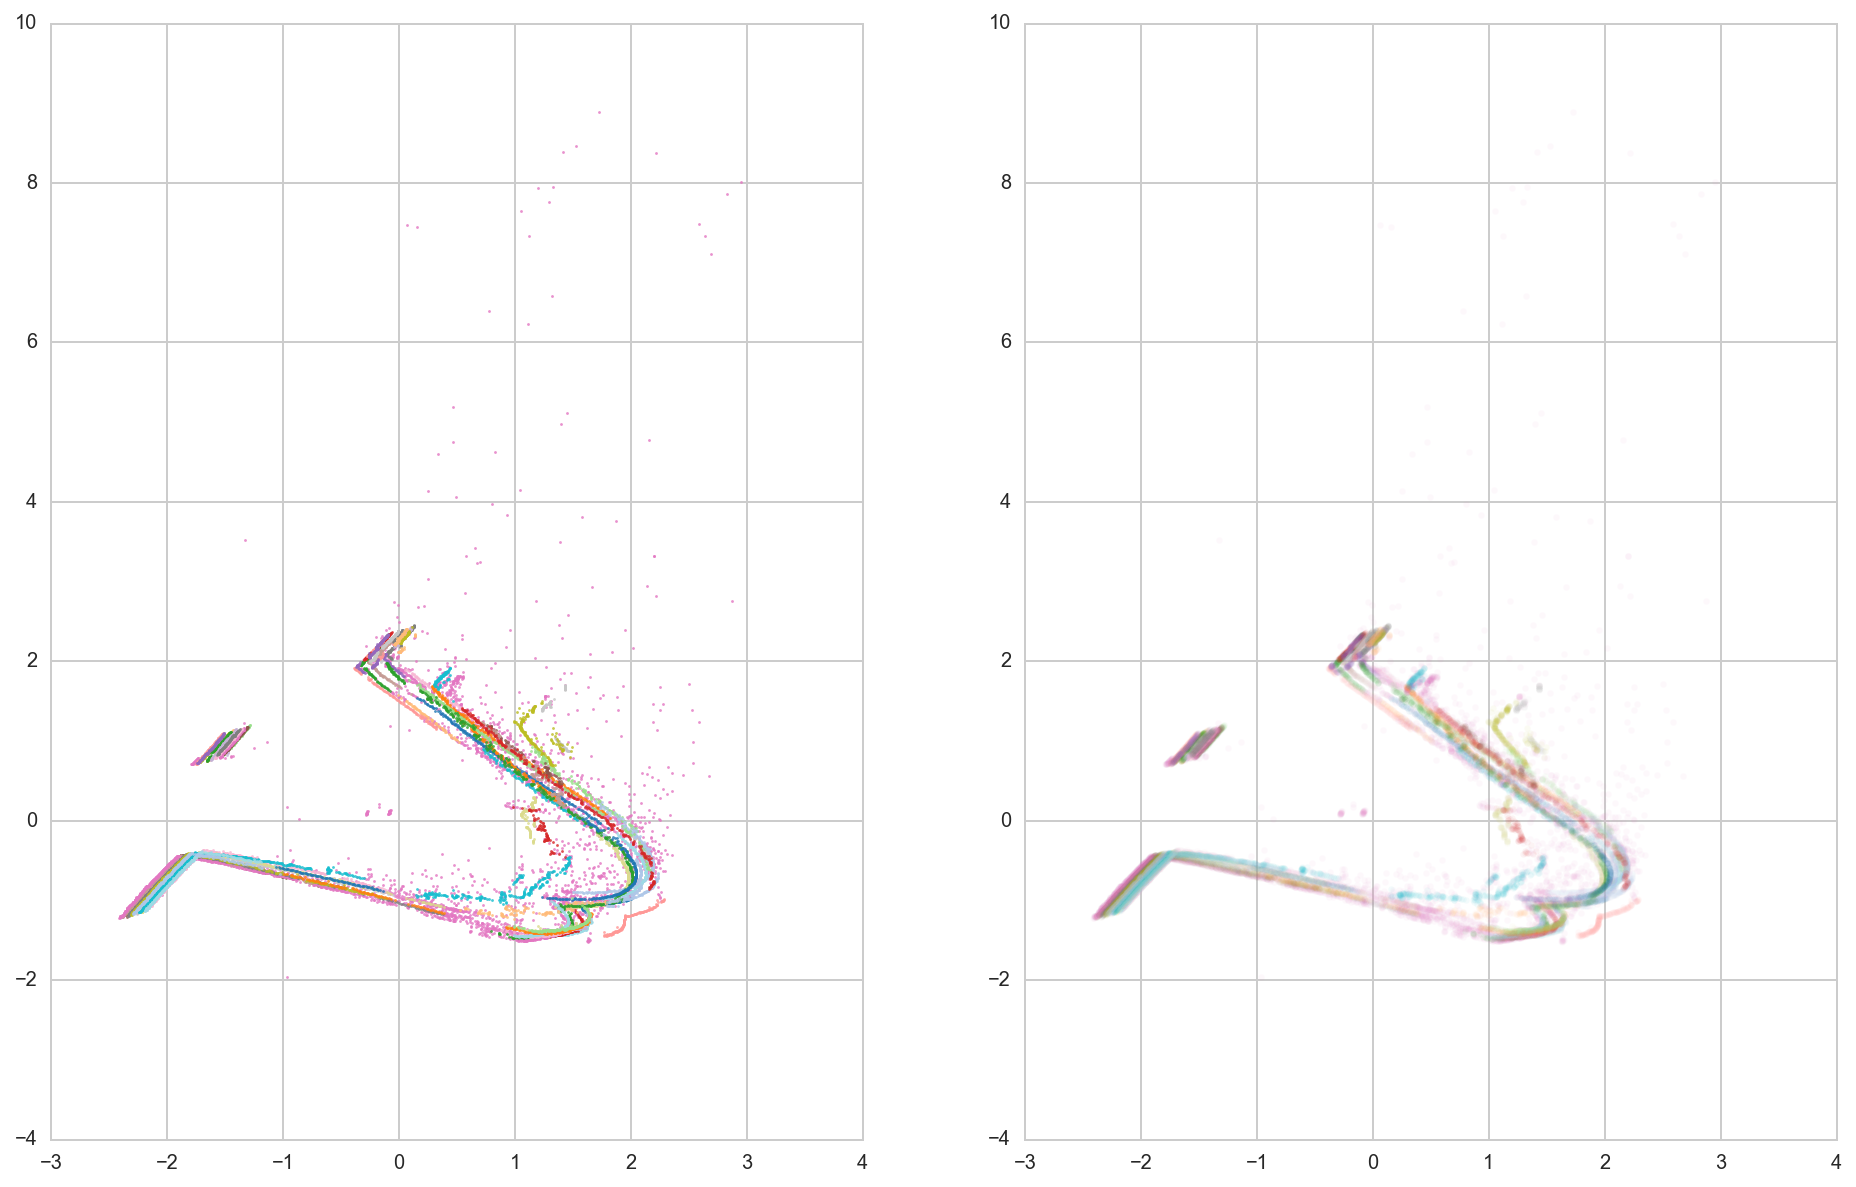

In [150]:
_plot_scatter(X_kpca_std, clusterer_hdbscan.labels_)

(16256, 7)
8


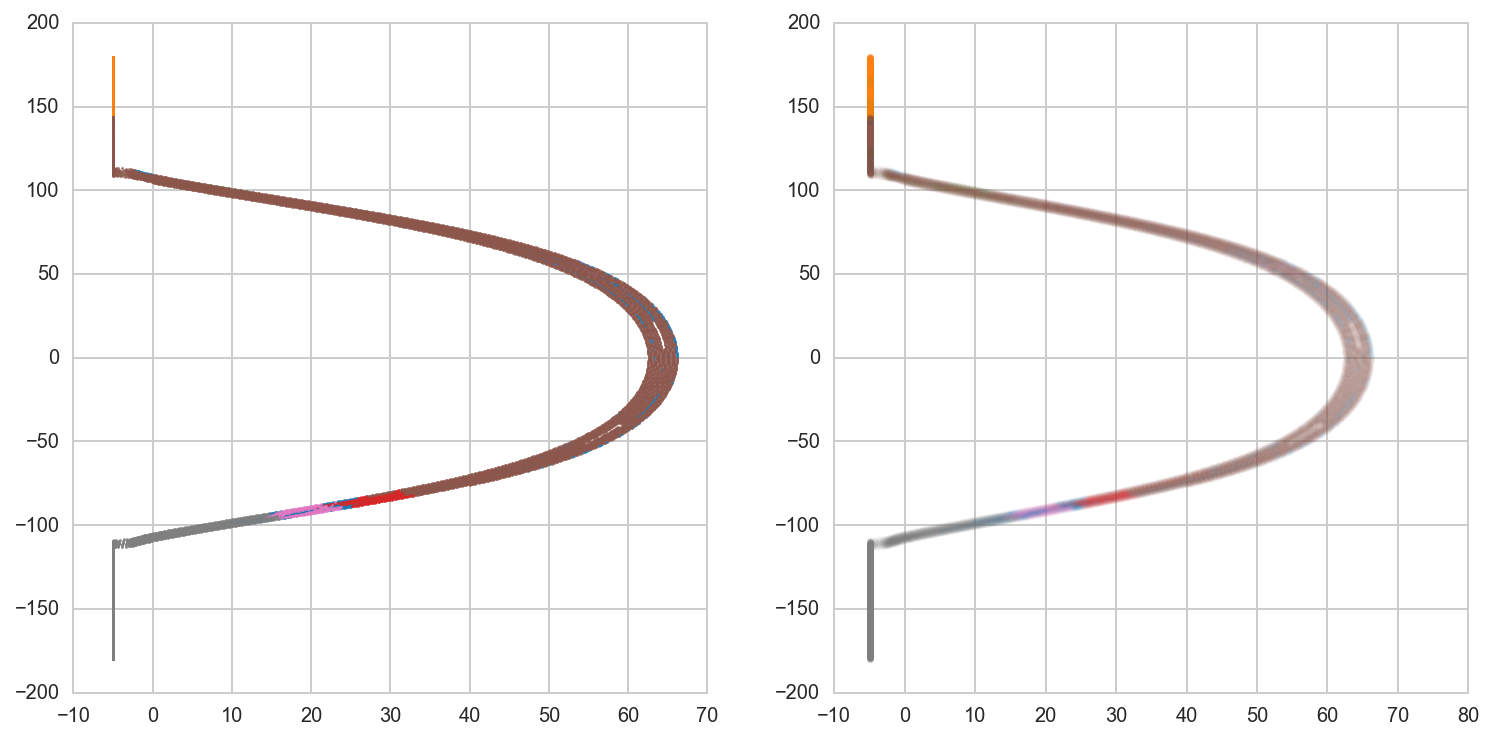

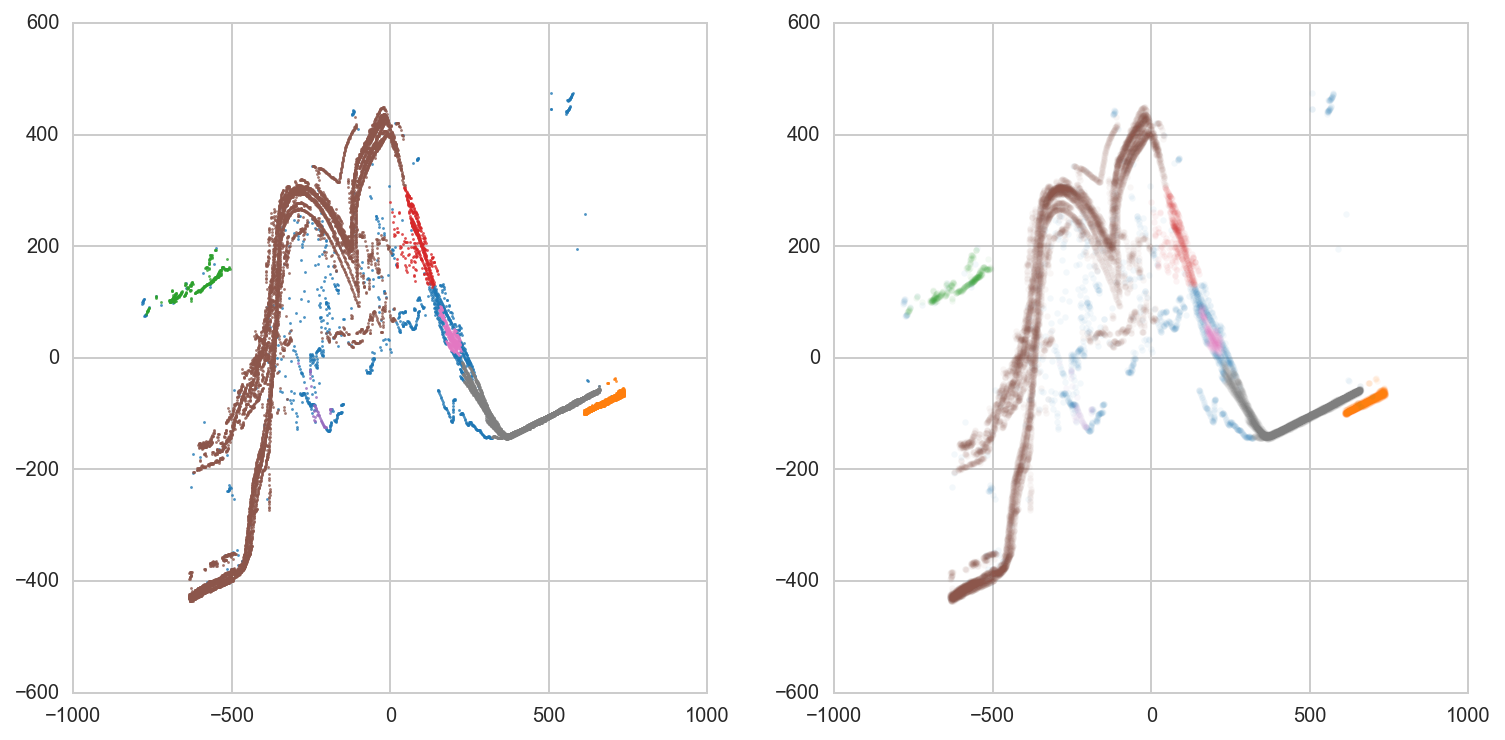

(16256, 2)
12


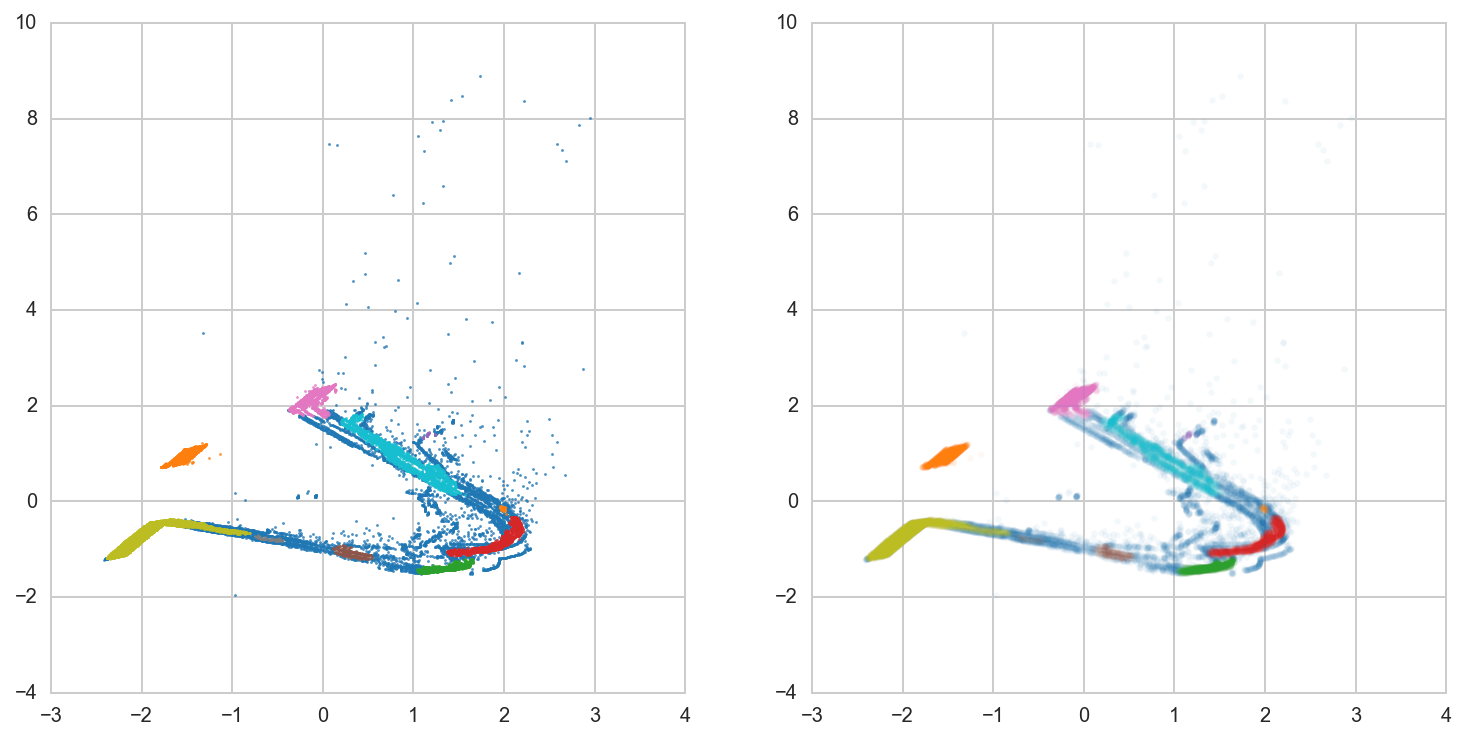

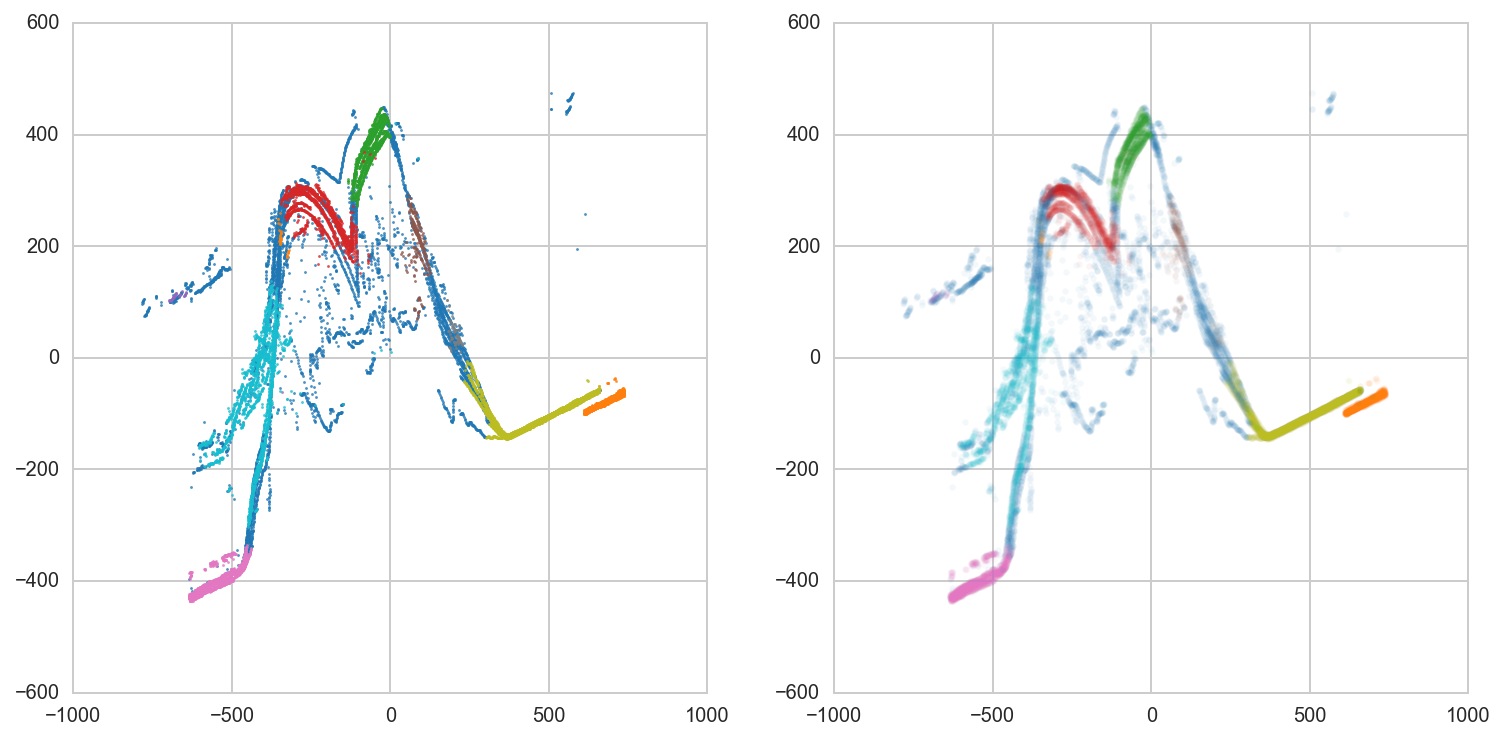

(16256, 2)
9


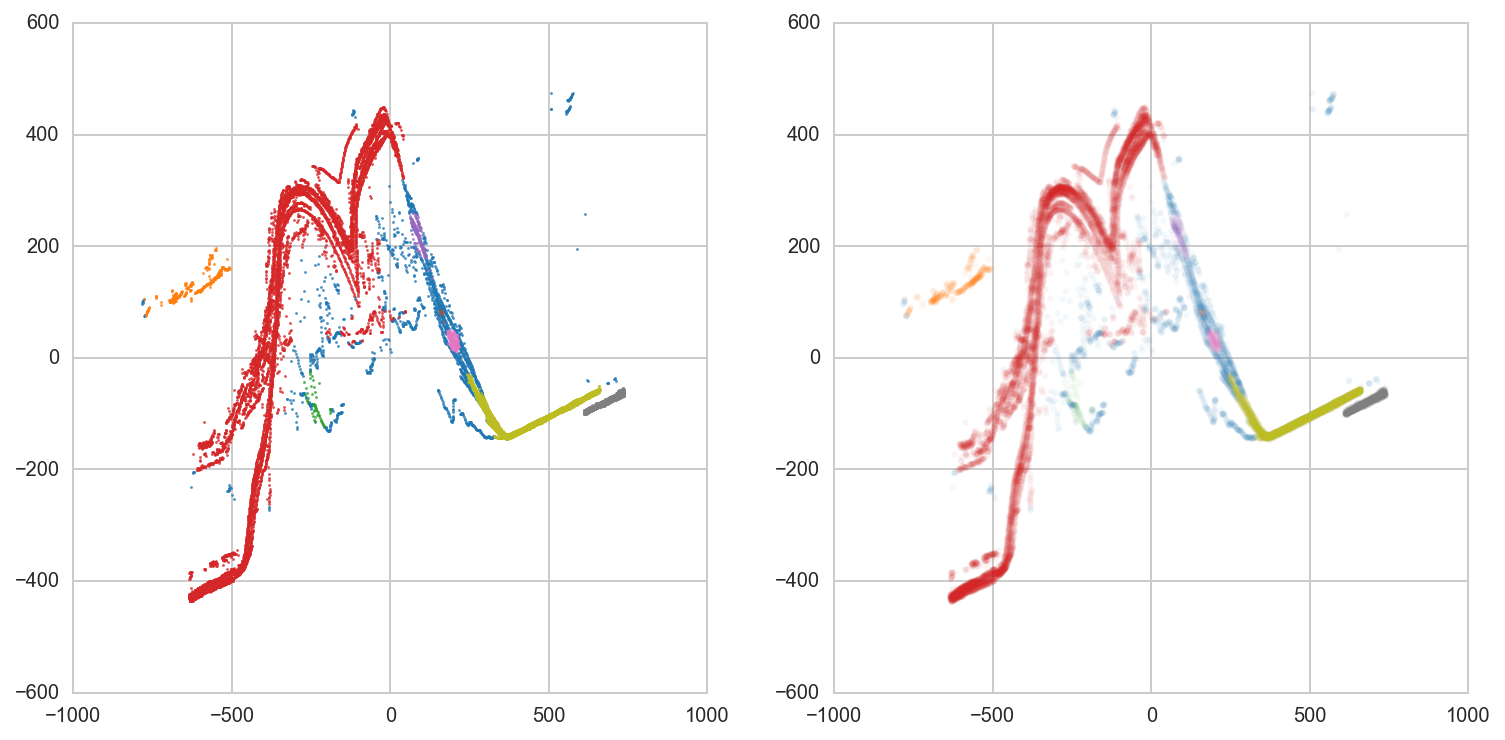

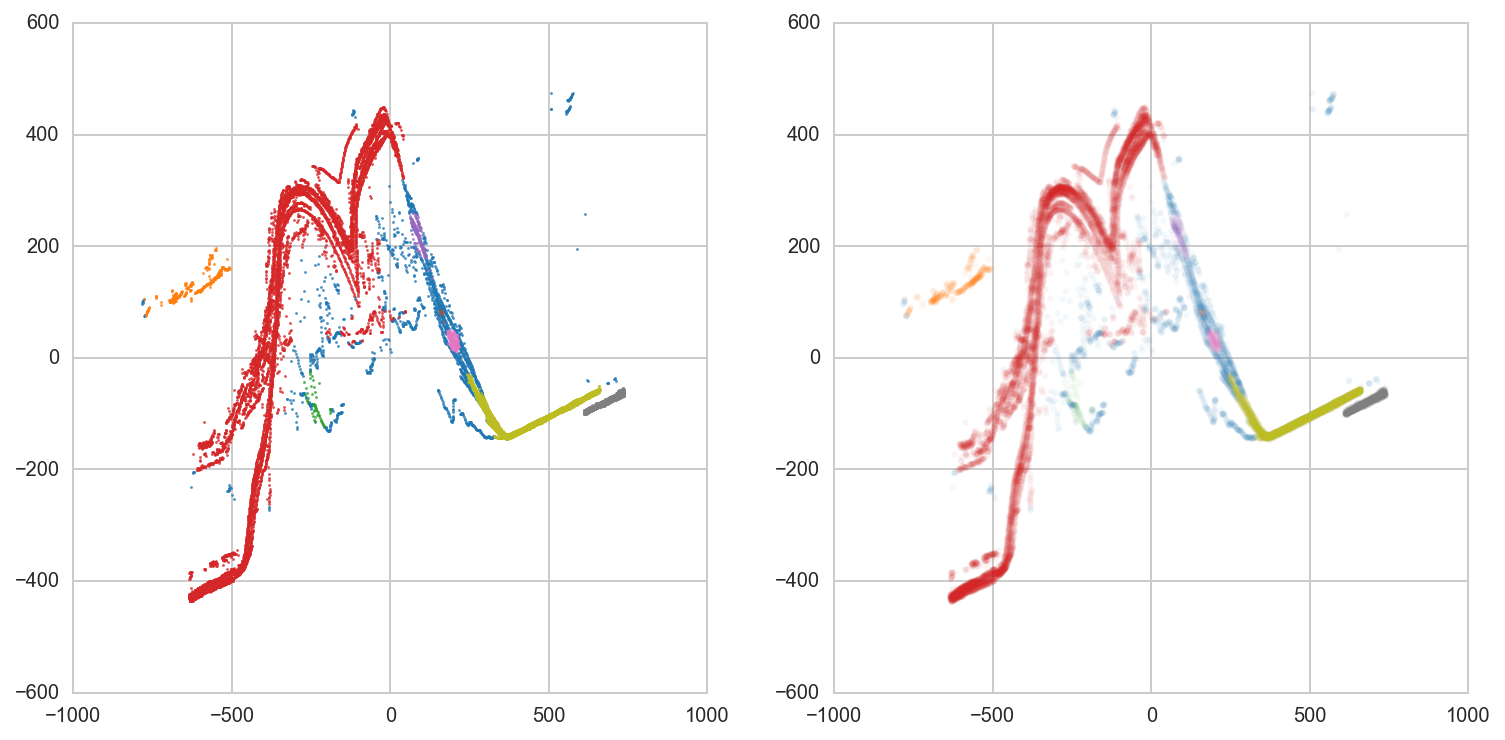

(16256, 2)
4


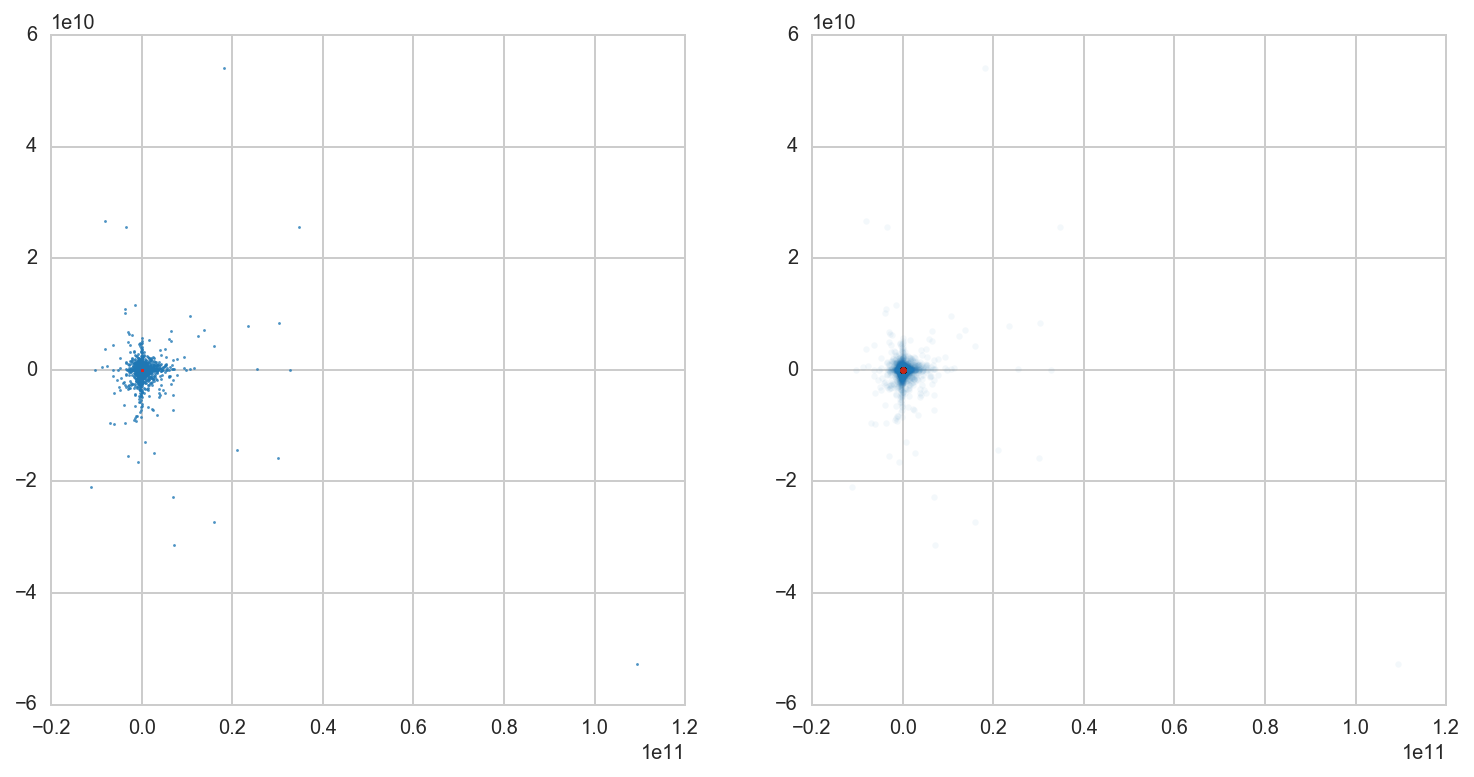

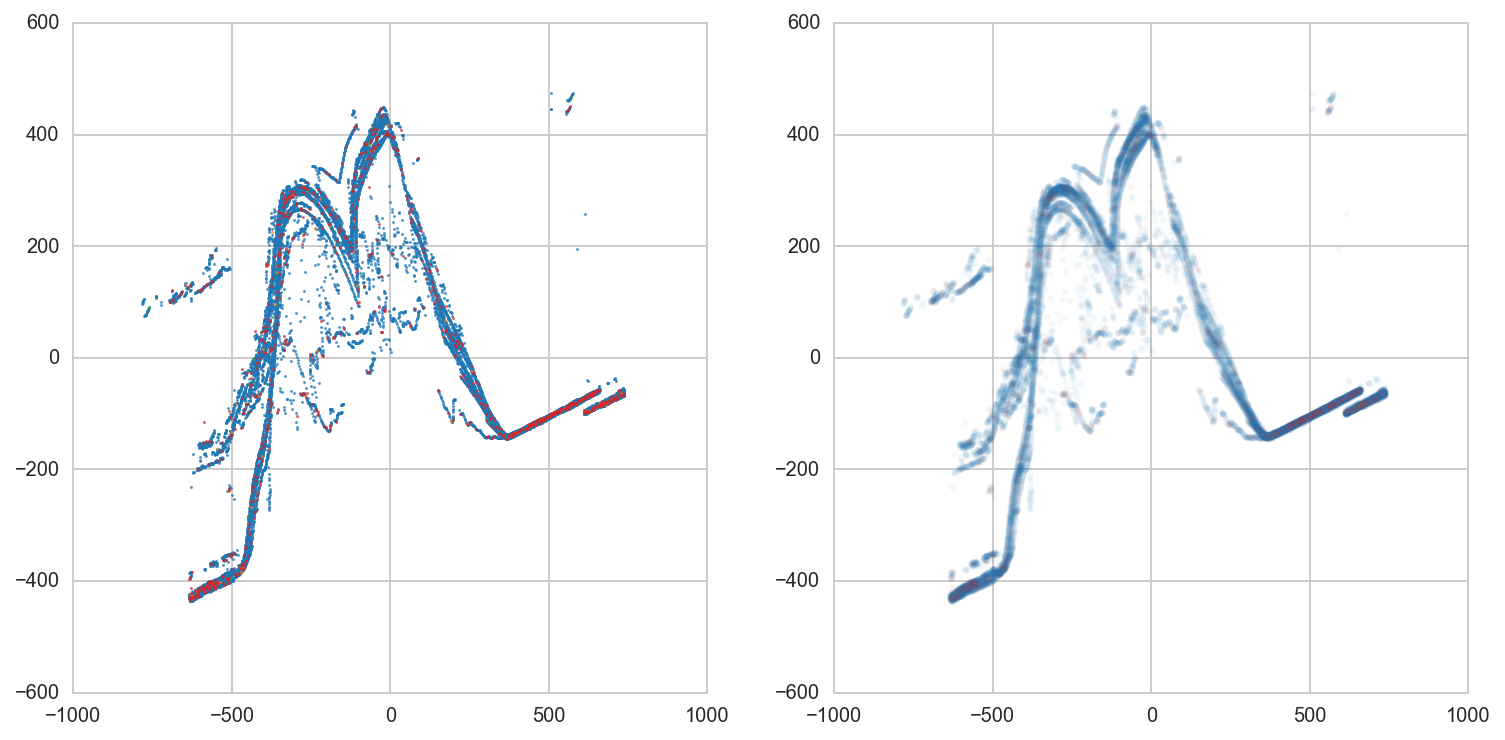

In [210]:
for x in [X, X_kpca_std, X_pca, tsne_reduced]:
    print_info(x.shape)
    clusterer_hdbscan = HDBSCAN(min_cluster_size=10, min_samples=100).fit(x)
    print_red(len(set(clusterer_hdbscan.labels_)))
    _plot_scatter(x, clusterer_hdbscan.labels_)
    _plot_scatter(X_pca, clusterer_hdbscan.labels_)
    plt.show()

In [159]:
features_std.corr()

altitude   azimuth    median       std     _step  minuteofday  dayofyear
altitude     1.000000  0.006053  0.867180  0.012862  0.000229     0.290303  -0.073101
azimuth      0.006053  1.000000  0.067808  0.068802 -0.021213     0.539340  -0.023976
median       0.867180  0.067808  1.000000  0.030743  0.003553     0.354406  -0.025322
std          0.012862  0.068802  0.030743  1.000000 -0.104736     0.062399  -0.025908
_step        0.000229 -0.021213  0.003553 -0.104736  1.000000    -0.019271   0.003178
minuteofday  0.290303  0.539340  0.354406  0.062399 -0.019271     1.000000  -0.055530
dayofyear   -0.073101 -0.023976 -0.025322 -0.025908  0.003178    -0.055530   1.000000

In [211]:
clusterer_hdbscan.labels_

array([-1, -1, -1, ..., -1, -1, -1])

In [204]:
from sklearn.linear_model import LinearRegression

data_ls = features_valid.copy() #.drop(['_step'], axis=1)
y_ls = data_ls['median'].values
X_ls = data_ls.drop(['median'], axis=1).values

LR = LinearRegression(n_jobs=-1)
LR.fit(X_ls, y_ls)
LR.score(X_ls, y_ls)

0.76552867912601141

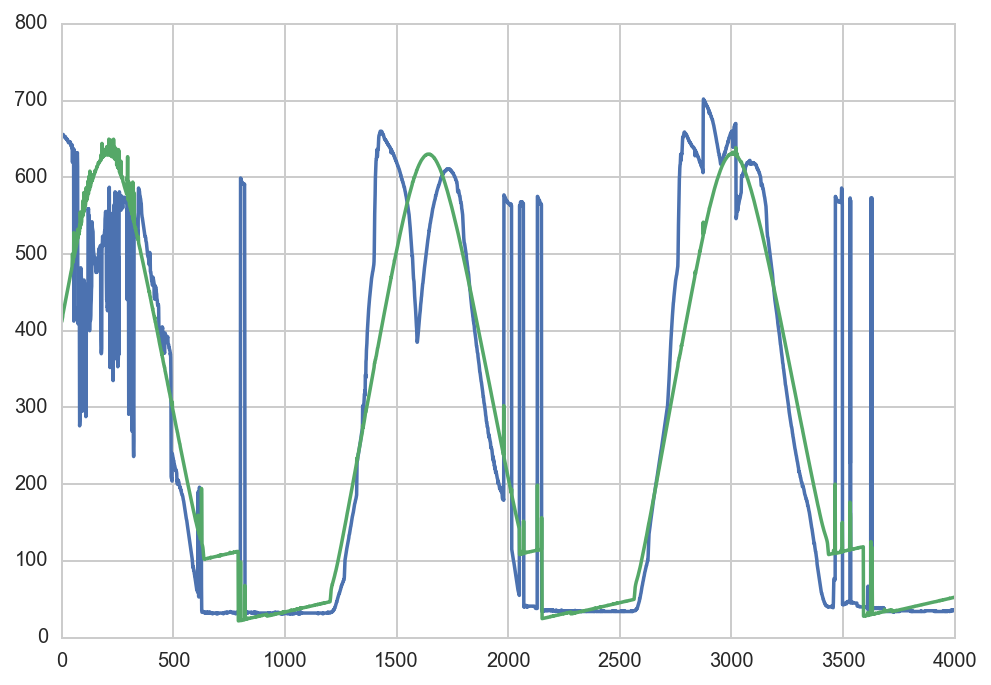

In [205]:
ax = plt.plot(y_ls[:4000])
plt.plot(LR.predict(X_ls)[:4000])

In [213]:
features_valid.head()

altitude    azimuth  median       std  _step  minuteofday  dayofyear
ts                                                                                              
2016-08-12 10:48:00+02:00  40.089949 -75.799303   656.0  0.129099   -1.0          648        225
2016-08-12 10:49:00+02:00  40.278964 -75.602273   654.0  0.911167   -2.0          649        225
2016-08-12 10:50:00+02:00  40.467812 -75.404416   654.0  0.936395   -1.0          650        225
2016-08-12 10:51:00+02:00  40.656493 -75.205719   656.0  0.945402    3.0          651        225
2016-08-12 10:52:00+02:00  40.844999 -75.006168   656.0  0.342803    0.0          652        225